In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Install relevant packages
# !pip install openpyxl==3.0.0    # upgrade from version 2
# !pip install imp

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import random
import multiprocessing as mp
# import dill
import progressbar
import datetime

# %load_ext autoreload
# %autoreload 2

In [19]:
# Install more packages
# !pip uninstall geopandas
!pip install pandas fiona shapely pyproj rtree
!pip install geopandas
import pandas as pd
import geopandas as gpd
import rtree
from shapely.geometry import Point, Polygon

# Set key root paths
root_path = '/content/drive/MyDrive/Million Measurements/Distributionpaper/'
shapedata_path = root_path + 'ShapefileData/'
welldata_path = root_path + 'WellData/'
result_path = root_path + 'results/'

# Load state boundary shapefiles
states = gpd.GeoDataFrame.from_file(shapedata_path + 'cb_2018_us_state_500k.shp')

# Define helper functions




In [8]:
# Converts data frame to geodf (to convert CSV files to geodataframes)
# df: Input data frame
# latname: Latitude coordinate name
# lonname: Longitude coordinate name
def cvt_point_to_geodf(df,latname='lat',lonname='lon'):
    df['coords'] = list(zip(df[lonname],df[latname]))
    df['coords'] = df['coords'].apply(Point)
    gdf = gpd.GeoDataFrame(df, geometry='coords')
    return gdf

# Add an indicator for whether a well was visited in a given month to a well-level data frame
def AssignMonthVisit(i,row):
    if row['month'] == i:
        return 1

# Weights production for each surveyed well by the number of visits in month "m" as a fraction of total visits
# e.g. if a well is visited twice in January and once in February, its weight for January will be 2/3
def weightByMonthlyVisits(m, monthly_visits):
  try:
    count_m = monthly_visits.iloc[m]
    count_t = monthly_visits.sum()
    return count_m/count_t
  except IndexError:
    return 0

# Oil production for surveyed wells in a given campaign in month m
def campaignmonthOilProd(m, w_in_campaign_groupby):
  return np.sum(w_in_campaign_groupby['Oil_' + m])

# Basin-wide oil production in month m
def basinmonthOilProd(m, basinname, w_in_basin_groupby):
  return w_in_basin_groupby[(w_in_basin_groupby['Name'] == basinname)].iloc[0]['Oil_' + m]

# Daily oil production in a given month by basin, weighted across the campaign
def basinmonthOilProdDaily(m, basinname, w_in_basin_groupby):
  d = {'Jan': 31, 'Feb': 28, 'Mar': 31, 'Apr': 30, 'May': 31, 'Jun': 30, 'Jul': 31, 'Aug': 31, 'Sep': 30, 'Oct': 31, 'Nov': 30, 'Dec': 31}
  daysPerMonth = pd.DataFrame(data=d, index=[0]) #.transpose()
  return w_in_basin_groupby[(w_in_basin_groupby['Name'] == selectBasin)].iloc[0]['Oil_' + m]/daysPerMonth.iloc[0,int(m)-1]

# Daily gas production in a given campaign in a given month
def campaignmonthGasProd(m, w_in_campaign_groupby):
  return np.sum(w_in_campaign_groupby['Gas_' + m])

# Daily gas production in a given campaign in a given month
def basinmonthGasProd(m, basinname, w_in_basin_groupby):
  return w_in_basin_groupby[(w_in_basin_groupby['Name'] == basinname)].iloc[0]['Gas_' + m]

# Daily oil production in a given month by basin, weighted across the campaign
def basinmonthGasProdDaily(m, basinname, w_in_basin_groupby):
  d = {'Jan': 31, 'Feb': 28, 'Mar': 31, 'Apr': 30, 'May': 31, 'Jun': 30, 'Jul': 31, 'Aug': 31, 'Sep': 30, 'Oct': 31, 'Nov': 30, 'Dec': 31}
  daysPerMonth = pd.DataFrame(data=d, index=[0]) #.transpose()
  return w_in_basin_groupby[(w_in_basin_groupby['Name'] == basinname)].iloc[0]['Gas_' + m]/daysPerMonth.iloc[0,int(m)-1]

# Compute average daily oil and gas production for each well in a data frame (from monthly input data)
# Monthly production data make it easy to do a properly weighted average (just divide total production over all months by days per year)
def generateAvgOilGasProd(wells):
  daysPerYear = 365
  wells['AvgDailyOil'] = (wells['Oil_01'] + wells['Oil_02'] + wells['Oil_03'] + wells['Oil_04'] + wells['Oil_05'] + wells['Oil_06'] + wells['Oil_07'] + wells['Oil_08'] + wells['Oil_09'] + wells['Oil_10'] + wells['Oil_11'] + wells['Oil_12'])/daysPerYear
  wells['AvgDailyGas'] = (wells['Gas_01'] + wells['Gas_02'] + wells['Gas_03'] + wells['Gas_04'] + wells['Gas_05'] + wells['Gas_06'] + wells['Gas_07'] + wells['Gas_08'] + wells['Gas_09'] + wells['Gas_10'] + wells['Gas_11'] + wells['Gas_12'])/daysPerYear
  return wells

# List of months in string and numeric form
monthStr = pd.DataFrame(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])
monthNum = pd.DataFrame(np.arange(12))

# Main function

In [9]:
# Full function to generate campaign-level summary statistics for analyzing the
# distribution of methane emissions

# By Evan Sherwin & Zhan Zhang
# August 2023

# Set inputs
# wellsheetname: String of the CSV file name, in the welldata_path folder
## Utah/Uinta: 'UT_2020_welldata.csv'
## Permian 2019: 'Permian_2019_welldata.csv'
## Permian 2021: 'Permian_2021_welldata.csv'
## Appalachian 2021: 'APP_2021_welldata.csv'
## California 2020 campaigns: 'CA_2020_welldata.csv'
## Denver 2021: 'DJ_2021_welldata.csv'
## Uinta 2020: 'UT_2020_welldata.csv'

# campaignname: The name of the campaign, used to select the correct campaign shapefile
## Utah/Uinta 2020: 'Utah_2020'
## Permian 2019: 'Permian_2019'
## Permian fall 2021: 'Permian_fall2021'
## Appalachian 2021: 'Northeast_2021'
## California fall 2020: 'Cal_fall2020'
## Denver Fall 2021: 'Denver_fall2021'

# selectBasin: The name of the basin for which to display key summary statistics
# Well productivity comparison
# 'Permian basin'
# 'Appalachian basin (eastern overthrust area)'
# 'San Joaquin basin'
# 'Denver basin'
# 'Uinta basin'
# 'Fort Worth syncline'

# todayDate: String of today's date, possibly with version letter on the end

# state: The state in which to limit analysis (False if no need to limit to a specific state)

# coveredwellsheetname: The name of any spreadsheet of covered well productivity and visits (needed for Kairos data only)

def distributionsSummaryStats(wellsheetname, campaignname, selectBasin, todaydate, scenarioname, state, coveredwellsheetname):

  # Filepaths for relevant input data
  root_path = '/content/drive/MyDrive/Million Measurements/Distributionpaper/'
  shapedata_path = root_path + 'ShapefileData/'
  welldata_path = root_path + 'WellData/'
  result_path = root_path + 'results/'

  # Load well-level data
  # wellsheetname = 'UT_2020_welldata.csv'
  wells = pd.read_csv(welldata_path + wellsheetname)
  wells = cvt_point_to_geodf(wells, lonname='Surface Hole Longitude (WGS84)', latname='Surface Hole Latitude (WGS84)')
  # Add daily average oil and gas production columns
  wells = generateAvgOilGasProd(wells)

  # Generate well columns
  month_num = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
  # month_num_nozero = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
  oil_cols_general = ['Oil_' + i for i in month_num]
  gas_cols_general = ['Gas_' + i for i in month_num]

  # Drop wells with zero oil or gas production
  wells['total_oil'] = wells.loc[:, oil_cols_general].sum(axis=1)
  wells['total_gas'] = wells.loc[:, gas_cols_general].sum(axis=1)
  wells = wells[(wells['total_oil'] + wells['total_gas']) > 0]

  # Load campaign polygons
  if (campaignname == 'Kairos'):
    campaign = 'Null' # For Kairos campaigns, a version of these functions is applied internally in Kairos servers to protect customer data
  else:
    campaign = gpd.GeoDataFrame.from_file(shapedata_path + campaignname + '.shp')

  # Import basin shapefile
  # Source: https://ngmdb.usgs.gov/Geolex/stratres/provinces
  basin = gpd.GeoDataFrame.from_file(shapedata_path + 'AAPGGeologicProvinces.shp')

  # Set the basin's name based on user input
  basinname = selectBasin

  # Add month to campaigns
  if (campaignname == 'Kairos'):
    'Null'
  else:
    if campaignname=='Cal_201617':
      campaign[["year", "month", "day"]] = campaign["datetime"].str.split("-", expand = True)
    else:
      campaign[["year", "month", "day"]] = campaign["date"].str.split("-", expand = True)

  # Import state shapefiles
  stateshapes = gpd.GeoDataFrame.from_file(shapedata_path + 'cb_2018_us_state_500k.shp')

  # Import Permian Fall 2021 shapefile
  PermianFall2021Campaign = gpd.GeoDataFrame.from_file(shapedata_path + 'Permian_fall2021.shp')
  PermianFall2021Campaign['CampaignID'] = 1
  PermianFall2021Dissolved = PermianFall2021Campaign.dissolve(by='CampaignID', aggfunc='first')

  # the state field is also used to restrict the domain of a campaign
  if state=='Permian_fall2021': # For cases where Permian 2019 data are restricted to the Permian Fall 2021 campaign
    stateshape = PermianFall2021Dissolved
  elif state=='Delaware_fall2021': # For cases where Permian 2019 data are restricted to the Delaware Fall 2021 campaign
    ymin, ymax, xmin, xmax = 0, 90, -110, -103
    selection_box = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)])
    stateshape = gpd.clip(PermianFall2021Dissolved, selection_box)
  elif state=='Midland_fall2021': # For cases where Permian 2019 data are restricted to the Midland Fall 2021 campaign
    ymin, ymax, xmin, xmax = 0, 90, -103, -90
    selection_box = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)])
    stateshape = gpd.clip(PermianFall2021Dissolved, selection_box)
  elif state=='Northeast_Pennsylvania': # Selects the surveyed portion of Northeast Pennsylvania, which largely overlaps with Barkley et al. 2017
    ymin, ymax, xmin, xmax = 41.5, 42, -78, -75.5
    selection_box = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)])
    stateshape = gpd.clip(stateshapes[stateshapes['NAME']=='Pennsylvania'], selection_box)
  elif state==False:
      False
  else:
      stateshape = stateshapes[stateshapes['NAME']==state]

  # Count all well visits at 1 initially (for aggregation after joining with campaign polygons)
  wells['count'] = 1

  # Join campaign polygons to well points
  if (campaignname == 'Kairos'):
    w_in_campaign = pd.read_csv(welldata_path + coveredwellsheetname)
    # Add 'count', rename AssetID as API14 to ensure logic is consistent
    w_in_campaign['count'] = 1
    w_in_campaign['API14'] = w_in_campaign['AssetID']
  else:
    w_in_campaign = gpd.tools.sjoin(wells,campaign,predicate='within',how='inner').drop('index_right', axis=1)
    w_in_campaign_cols = (w_in_campaign.columns).drop(['coords'])

  # Drop selected columns from campaigns to allow spatial joins
  flightline_cols_to_drop = list(set(['OBJECTID', 'flightline', 'date',
      'datetime', 'platform', 'campaign', 'Shape_Leng', 'Shape_Area']) & set(w_in_campaign.columns))
  # flightline_cols_to_drop = ['OBJECTID', 'flightline', 'date',
  #       'datetime', 'platform', 'campaign', 'Shape_Leng', 'Shape_Area']

  # Select wells within a campaign or sub-selected area of a campaign
  if state==False:
    w_in_campaign
  elif (state=='Permian_fall2021') | (state=='Delaware_fall2021') | (state=='Midland_fall2021'):
    w_in_campaign = gpd.tools.sjoin(stateshape, w_in_campaign.drop(flightline_cols_to_drop, axis=1), predicate='contains', how='inner')[w_in_campaign_cols]
  else:
    w_in_campaign = gpd.tools.sjoin(stateshape, w_in_campaign, predicate='contains', how='inner')[w_in_campaign_cols]

  # Sort wells in campaign by API14 identifier
  w_in_campaign = w_in_campaign.sort_values(by=['API14'])

  # Add 12 columns of number of visits for each well
  if (campaignname == 'Kairos'):
    'Null'
  else:
    w_in_campaign['Visit_01'] = 0
    w_in_campaign['Visit_02'] = 0
    w_in_campaign['Visit_03'] = 0
    w_in_campaign['Visit_04'] = 0
    w_in_campaign['Visit_05'] = 0
    w_in_campaign['Visit_06'] = 0
    w_in_campaign['Visit_07'] = 0
    w_in_campaign['Visit_08'] = 0
    w_in_campaign['Visit_09'] = 0
    w_in_campaign['Visit_10'] = 0
    w_in_campaign['Visit_11'] = 0
    w_in_campaign['Visit_12'] = 0

    # Populate these columns with indicators of whether a given well was visited in a given month in this campaign
    # Can include multiple visits in the same month, as each row corresponds to a well visit
    w_in_campaign['Visit_01'] = w_in_campaign.apply(lambda row: AssignMonthVisit('01', row), axis=1)
    w_in_campaign['Visit_02'] = w_in_campaign.apply(lambda row: AssignMonthVisit('02', row), axis=1)
    w_in_campaign['Visit_03'] = w_in_campaign.apply(lambda row: AssignMonthVisit('03', row), axis=1)
    w_in_campaign['Visit_04'] = w_in_campaign.apply(lambda row: AssignMonthVisit('04', row), axis=1)
    w_in_campaign['Visit_05'] = w_in_campaign.apply(lambda row: AssignMonthVisit('05', row), axis=1)
    w_in_campaign['Visit_06'] = w_in_campaign.apply(lambda row: AssignMonthVisit('06', row), axis=1)
    w_in_campaign['Visit_07'] = w_in_campaign.apply(lambda row: AssignMonthVisit('07', row), axis=1)
    w_in_campaign['Visit_08'] = w_in_campaign.apply(lambda row: AssignMonthVisit('08', row), axis=1)
    w_in_campaign['Visit_09'] = w_in_campaign.apply(lambda row: AssignMonthVisit('09', row), axis=1)
    w_in_campaign['Visit_10'] = w_in_campaign.apply(lambda row: AssignMonthVisit('10', row), axis=1)
    w_in_campaign['Visit_11'] = w_in_campaign.apply(lambda row: AssignMonthVisit('11', row), axis=1)
    w_in_campaign['Visit_12'] = w_in_campaign.apply(lambda row: AssignMonthVisit('12', row), axis=1)

  # Compute days per month
  d = {'Jan': 31, 'Feb': 28, 'Mar': 31, 'Apr': 30, 'May': 31, 'Jun': 30, 'Jul': 31, 'Aug': 31, 'Sep': 30, 'Oct': 31, 'Nov': 30, 'Dec': 31}
  daysPerMonth = pd.DataFrame(data=d, index=[0]) #.transpose()

  # Compute a single row with daily gas production during each well visit
  w_in_campaign['VisitProdGas'] = 0
  w_in_campaign.loc[w_in_campaign['Visit_01']==1, 'VisitProdGas'] = w_in_campaign.loc[w_in_campaign['Visit_01']==1, 'Gas_01']/daysPerMonth.loc[0, 'Jan']
  w_in_campaign.loc[w_in_campaign['Visit_02']==1, 'VisitProdGas'] = w_in_campaign.loc[w_in_campaign['Visit_02']==1, 'Gas_02']/daysPerMonth.loc[0, 'Feb']
  w_in_campaign.loc[w_in_campaign['Visit_03']==1, 'VisitProdGas'] = w_in_campaign.loc[w_in_campaign['Visit_03']==1, 'Gas_03']/daysPerMonth.loc[0, 'Mar']
  w_in_campaign.loc[w_in_campaign['Visit_04']==1, 'VisitProdGas'] = w_in_campaign.loc[w_in_campaign['Visit_04']==1, 'Gas_04']/daysPerMonth.loc[0, 'Apr']
  w_in_campaign.loc[w_in_campaign['Visit_05']==1, 'VisitProdGas'] = w_in_campaign.loc[w_in_campaign['Visit_05']==1, 'Gas_05']/daysPerMonth.loc[0, 'May']
  w_in_campaign.loc[w_in_campaign['Visit_06']==1, 'VisitProdGas'] = w_in_campaign.loc[w_in_campaign['Visit_06']==1, 'Gas_06']/daysPerMonth.loc[0, 'Jun']
  w_in_campaign.loc[w_in_campaign['Visit_07']==1, 'VisitProdGas'] = w_in_campaign.loc[w_in_campaign['Visit_07']==1, 'Gas_07']/daysPerMonth.loc[0, 'Jul']
  w_in_campaign.loc[w_in_campaign['Visit_08']==1, 'VisitProdGas'] = w_in_campaign.loc[w_in_campaign['Visit_08']==1, 'Gas_08']/daysPerMonth.loc[0, 'Aug']
  w_in_campaign.loc[w_in_campaign['Visit_09']==1, 'VisitProdGas'] = w_in_campaign.loc[w_in_campaign['Visit_09']==1, 'Gas_09']/daysPerMonth.loc[0, 'Sep']
  w_in_campaign.loc[w_in_campaign['Visit_10']==1, 'VisitProdGas'] = w_in_campaign.loc[w_in_campaign['Visit_10']==1, 'Gas_10']/daysPerMonth.loc[0, 'Oct']
  w_in_campaign.loc[w_in_campaign['Visit_11']==1, 'VisitProdGas'] = w_in_campaign.loc[w_in_campaign['Visit_11']==1, 'Gas_11']/daysPerMonth.loc[0, 'Nov']
  w_in_campaign.loc[w_in_campaign['Visit_12']==1, 'VisitProdGas'] = w_in_campaign.loc[w_in_campaign['Visit_12']==1, 'Gas_12']/daysPerMonth.loc[0, 'Dec']

  # Compute a single row with daily oil production during each well visit
  w_in_campaign['VisitProdOil'] = 0
  w_in_campaign.loc[w_in_campaign['Visit_01']==1, 'VisitProdOil'] = w_in_campaign.loc[w_in_campaign['Visit_01']==1, 'Oil_01']/daysPerMonth.loc[0, 'Jan']
  w_in_campaign.loc[w_in_campaign['Visit_02']==1, 'VisitProdOil'] = w_in_campaign.loc[w_in_campaign['Visit_02']==1, 'Oil_02']/daysPerMonth.loc[0, 'Feb']
  w_in_campaign.loc[w_in_campaign['Visit_03']==1, 'VisitProdOil'] = w_in_campaign.loc[w_in_campaign['Visit_03']==1, 'Oil_03']/daysPerMonth.loc[0, 'Mar']
  w_in_campaign.loc[w_in_campaign['Visit_04']==1, 'VisitProdOil'] = w_in_campaign.loc[w_in_campaign['Visit_04']==1, 'Oil_04']/daysPerMonth.loc[0, 'Apr']
  w_in_campaign.loc[w_in_campaign['Visit_05']==1, 'VisitProdOil'] = w_in_campaign.loc[w_in_campaign['Visit_05']==1, 'Oil_05']/daysPerMonth.loc[0, 'May']
  w_in_campaign.loc[w_in_campaign['Visit_06']==1, 'VisitProdOil'] = w_in_campaign.loc[w_in_campaign['Visit_06']==1, 'Oil_06']/daysPerMonth.loc[0, 'Jun']
  w_in_campaign.loc[w_in_campaign['Visit_07']==1, 'VisitProdOil'] = w_in_campaign.loc[w_in_campaign['Visit_07']==1, 'Oil_07']/daysPerMonth.loc[0, 'Jul']
  w_in_campaign.loc[w_in_campaign['Visit_08']==1, 'VisitProdOil'] = w_in_campaign.loc[w_in_campaign['Visit_08']==1, 'Oil_08']/daysPerMonth.loc[0, 'Aug']
  w_in_campaign.loc[w_in_campaign['Visit_09']==1, 'VisitProdOil'] = w_in_campaign.loc[w_in_campaign['Visit_09']==1, 'Oil_09']/daysPerMonth.loc[0, 'Sep']
  w_in_campaign.loc[w_in_campaign['Visit_10']==1, 'VisitProdOil'] = w_in_campaign.loc[w_in_campaign['Visit_10']==1, 'Oil_10']/daysPerMonth.loc[0, 'Oct']
  w_in_campaign.loc[w_in_campaign['Visit_11']==1, 'VisitProdOil'] = w_in_campaign.loc[w_in_campaign['Visit_11']==1, 'Oil_11']/daysPerMonth.loc[0, 'Nov']
  w_in_campaign.loc[w_in_campaign['Visit_12']==1, 'VisitProdOil'] = w_in_campaign.loc[w_in_campaign['Visit_12']==1, 'Oil_12']/daysPerMonth.loc[0, 'Dec']

  # Aggregate well-level campaign data to sum across all production from and visits to the same well, compute average production while covered for each well in the 'VisitProdGas' column
  if (campaignname == 'Kairos'):
    w_in_campaign_groupby = w_in_campaign.groupby(['API14']).agg({'count': np.sum,
                                                                'Oil_01': 'first', 'Oil_02': 'first', 'Oil_03': 'first', 'Oil_04': 'first', 'Oil_05': 'first', 'Oil_06': 'first', 'Oil_07': 'first', 'Oil_08': 'first', 'Oil_09': 'first', 'Oil_10': 'first', 'Oil_11': 'first', 'Oil_12': 'first',
                                                                'Gas_01': 'first', 'Gas_02': 'first', 'Gas_03': 'first', 'Gas_04': 'first', 'Gas_05': 'first', 'Gas_06': 'first', 'Gas_07': 'first', 'Gas_08': 'first', 'Gas_09': 'first', 'Gas_10': 'first', 'Gas_11': 'first', 'Gas_12': 'first',
                                                                'Visit_01': np.sum, 'Visit_02': np.sum, 'Visit_03': np.sum, 'Visit_04': np.sum, 'Visit_05': np.sum, 'Visit_06': np.sum, 'Visit_07': np.sum, 'Visit_08': np.sum, 'Visit_09': np.sum, 'Visit_10': np.sum, 'Visit_11': np.sum, 'Visit_12': np.sum, 'VisitProdGas':'mean', 'VisitProdOil':'mean'})
  else:
    w_in_campaign_groupby = w_in_campaign.groupby(['API14']).agg({'Surface Hole Latitude (WGS84)': 'first', 'Surface Hole Longitude (WGS84)': 'first', 'count': np.sum,
                                                                'Oil_01': 'first', 'Oil_02': 'first', 'Oil_03': 'first', 'Oil_04': 'first', 'Oil_05': 'first', 'Oil_06': 'first', 'Oil_07': 'first', 'Oil_08': 'first', 'Oil_09': 'first', 'Oil_10': 'first', 'Oil_11': 'first', 'Oil_12': 'first',
                                                                'Gas_01': 'first', 'Gas_02': 'first', 'Gas_03': 'first', 'Gas_04': 'first', 'Gas_05': 'first', 'Gas_06': 'first', 'Gas_07': 'first', 'Gas_08': 'first', 'Gas_09': 'first', 'Gas_10': 'first', 'Gas_11': 'first', 'Gas_12': 'first',
                                                                'Visit_01': np.sum, 'Visit_02': np.sum, 'Visit_03': np.sum, 'Visit_04': np.sum, 'Visit_05': np.sum, 'Visit_06': np.sum, 'Visit_07': np.sum, 'Visit_08': np.sum, 'Visit_09': np.sum, 'Visit_10': np.sum, 'Visit_11': np.sum, 'Visit_12': np.sum, 'VisitProdGas':'mean', 'VisitProdOil':'mean'})
  # Reset the index of the joined data frame
  w_in_campaign_groupby = w_in_campaign_groupby.reset_index()

  # Convert the joined data frame to a geodataframe
  if (campaignname == 'Kairos'):
      'Null'
  else:
    w_in_campaign_groupby = cvt_point_to_geodf(w_in_campaign_groupby, lonname='Surface Hole Longitude (WGS84)', latname='Surface Hole Latitude (WGS84)')
  # w_in_campaign_groupby

  # Join basins with well visits to indicate which well visits in a given campaign are in a given basin
  if (campaignname == 'Kairos'):
    basin_containwell = w_in_campaign_groupby
    # Add a province code and Name to ease computation of summary statistics
    basin_containwell['Prov_Cod_1'] = 1
    basin_containwell['Name'] = selectBasin

  else:
    basin_containwell = gpd.tools.sjoin(basin, w_in_campaign_groupby)
    basin_containwell = cvt_point_to_geodf(basin_containwell, latname='Surface Hole Latitude (WGS84)', lonname='Surface Hole Longitude (WGS84)')
    basin_containwell_cols = (basin_containwell.columns).drop(['coords', 'index_right', 'geometry'])
    if state==False:
      basin_containwell
    elif (state=='Permian_fall2021') | (state=='Delaware_fall2021') | (state=='Midland_fall2021'):
      basin_containwell = gpd.tools.sjoin(stateshape, basin_containwell.drop(['index_right', 'OBJECTID', 'Shape_Leng', 'Shape_Area'], axis=1), predicate='contains', how='inner')[basin_containwell_cols]
    else:
      # basin_containwell = gpd.tools.sjoin(stateshape, basin_containwell, predicate='contains', how='inner')[basin_containwell_cols]
      basin_containwell = gpd.tools.sjoin(stateshape, basin_containwell.drop(['index_right'], axis=1), predicate='contains', how='inner')[basin_containwell_cols]

  # Select oil and gas monthly production columns, monthly visit columns
  oil_prod_monthly_cols = ['Oil_01', 'Oil_02', 'Oil_03', 'Oil_04', 'Oil_05', 'Oil_06', 'Oil_07', 'Oil_08', 'Oil_09', 'Oil_10', 'Oil_11', 'Oil_12']
  gas_prod_monthly_cols = ['Gas_01', 'Gas_02', 'Gas_03', 'Gas_04', 'Gas_05', 'Gas_06', 'Gas_07', 'Gas_08', 'Gas_09', 'Gas_10', 'Gas_11', 'Gas_12']
  visit_count_monthly_cols = ['Visit_01', 'Visit_02', 'Visit_03', 'Visit_04', 'Visit_05', 'Visit_06', 'Visit_07', 'Visit_08', 'Visit_09', 'Visit_10', 'Visit_11', 'Visit_12']

  # Count the number of wells in a given basin in a given campaign
  basin_containwell['well_count'] = 1
  if (campaignname == 'Kairos'):
    basin_containwell['rpt_well_count'] = basin_containwell[visit_count_monthly_cols].sum(axis=1)
  else:
    basin_containwell['rpt_well_count'] = basin_containwell['count']

  # Create properly indexed vectors of days per month for each set of relevant columns
  daysPerMonthOil = daysPerMonth.copy()
  daysPerMonthOil.columns = oil_prod_monthly_cols
  daysPerMonthOil = daysPerMonthOil.loc[0,:]

  daysPerMonthGas = daysPerMonth.copy()
  daysPerMonthGas.columns = gas_prod_monthly_cols
  daysPerMonthGas = daysPerMonthGas.loc[0,:]

  daysPerMonthVisit = daysPerMonth.copy()
  daysPerMonthVisit.columns = visit_count_monthly_cols
  daysPerMonthVisit = daysPerMonthVisit.loc[0,:]

  # Count production covered on a repeated basis (if a given well is visited twice, its production is counted twice)
  # Normalize from monthly to daily production (none of the campaigns cover February, so no need to worry about leap days)
  # mcf(NG)/d

  basin_containwell['rpt_Oil'] = (basin_containwell[oil_prod_monthly_cols] * np.array(basin_containwell[visit_count_monthly_cols]) / daysPerMonthOil).sum(axis=1)
  basin_containwell['rpt_Gas'] = (basin_containwell[gas_prod_monthly_cols] * np.array(basin_containwell[visit_count_monthly_cols]) / daysPerMonthGas).sum(axis=1)

  # Computes average daily oil and natural gas production volume for each covered well during the study period (weighting for the length of each month and the number of well visits in each month)
  # mcf(NG)/d
  basin_containwell['avg_Oil'] = (basin_containwell[oil_prod_monthly_cols] * np.array(basin_containwell[visit_count_monthly_cols])).sum(axis=1) / np.array(basin_containwell[visit_count_monthly_cols]*daysPerMonthVisit).sum(axis=1)
  basin_containwell['avg_Gas'] = (basin_containwell[gas_prod_monthly_cols] * np.array(basin_containwell[visit_count_monthly_cols])).sum(axis=1) / np.array(basin_containwell[visit_count_monthly_cols]*daysPerMonthVisit).sum(axis=1)

  # Sort by well API number
  basin_containwell = basin_containwell.sort_values(by=['API14'])

  # Aggregate well-level summary statistics by basin
  basin_containwell_groupby = basin_containwell.groupby(['Prov_Cod_1']).agg({'Name': 'first', 'well_count': np.sum, 'rpt_well_count': np.sum, 'avg_Oil': np.sum, 'rpt_Oil': np.sum, 'avg_Gas': np.sum, 'rpt_Gas': np.sum})
  basin_containwell_groupby = basin_containwell_groupby.reset_index()

  ## Well-level productivity statistics
  # Compute wells that are in a basin at all, regardless of coverage
  basin_containwell_at_all = gpd.tools.sjoin(basin, wells)
  basin_containwell_groupby_at_all = basin_containwell_at_all.groupby(['Prov_Cod_1']).agg({'Name': 'first', 'count': np.sum, 'Gas_01': np.sum, 'Gas_02': np.sum, 'Gas_03': np.sum, 'Gas_04': np.sum, 'Gas_05': np.sum, 'Gas_06': np.sum, 'Gas_07': np.sum, 'Gas_08': np.sum, 'Gas_09': np.sum, 'Gas_10': np.sum, 'Gas_11': np.sum, 'Gas_12': np.sum, 'Oil_01': np.sum, 'Oil_02': np.sum, 'Oil_03': np.sum, 'Oil_04': np.sum, 'Oil_05': np.sum, 'Oil_06': np.sum, 'Oil_07': np.sum, 'Oil_08': np.sum, 'Oil_09': np.sum, 'Oil_10': np.sum, 'Oil_11': np.sum, 'Oil_12': np.sum})
  basin_containwell_groupby_at_all = basin_containwell_groupby_at_all.reset_index()

  # Select only wells and summary stats from the selected basin
  slct_basin_containwell_groupby_at_all = basin_containwell_groupby_at_all.loc[basin_containwell_groupby_at_all['Name']==selectBasin]
  slct_basin_campaign_summary_stats = basin_containwell_groupby.loc[basin_containwell_groupby["Name"]==selectBasin, :]
  slct_basin_campaign_summary_stats.insert(loc=0, column='Campaign name', value=campaignname)
  slct_basin_campaign_summary_stats.insert(loc=0, column='Scenario name', value=scenarioname)
  slct_basin_campaign_summary_stats['basin_well_count'] = slct_basin_containwell_groupby_at_all.loc[slct_basin_containwell_groupby_at_all['Name']==selectBasin, 'count'].iloc[0]

  ## Compute total production and fraction of production during the campaign period
  # Join campaign polygons to basins to generate monthly flight counts fraction
  # basin_well_visits_by_month = basin_containwell[visit_count_monthly_cols].sum(axis=0)
  basin_well_visits_by_month = basin_containwell.loc[basin_containwell.Name == selectBasin, visit_count_monthly_cols].sum(axis=0)

  # Join basin to wells to generate basin-total production in each month
  wells['w_count'] = 1

  # Select wells in the selected basin
  w_in_basin = gpd.tools.sjoin(wells,basin,predicate='within',how='inner').drop('index_right', axis=1)

  # Drop coordinates from columns of this data frame
  w_in_basin_cols = (w_in_basin.columns).drop('coords')

  # Select wells in the selected basin, and also within the selected sub-campaign if applicable
  if state==False:
    w_in_basin
  elif (state=='Permian_fall2021') | (state=='Delaware_fall2021') | (state=='Midland_fall2021'):
    w_in_basin = gpd.tools.sjoin(stateshape, w_in_basin.drop(['OBJECTID', 'Shape_Leng', 'Shape_Area'], axis=1), predicate='contains', how='inner')[w_in_basin_cols]
  else:
    w_in_basin = gpd.tools.sjoin(stateshape, w_in_basin, predicate='contains', how='inner')[w_in_basin_cols]

  # Sum well-level production values across all basins in the campaign
  w_in_basin_groupby = w_in_basin.groupby(['Name']).agg({'Prov_Cod_1': 'first', 'w_count': np.sum, 'Oil_01': np.sum, 'Oil_02': np.sum, 'Oil_03': np.sum, 'Oil_04': np.sum, 'Oil_05': np.sum, 'Oil_06': np.sum, 'Oil_07': np.sum, 'Oil_08': np.sum, 'Oil_09': np.sum, 'Oil_10': np.sum, 'Oil_11': np.sum, 'Oil_12': np.sum, 'Gas_01': np.sum, 'Gas_02': np.sum, 'Gas_03': np.sum, 'Gas_04': np.sum, 'Gas_05': np.sum, 'Gas_06': np.sum, 'Gas_07': np.sum, 'Gas_08': np.sum, 'Gas_09': np.sum, 'Gas_10': np.sum, 'Gas_11': np.sum, 'Gas_12': np.sum})
  w_in_basin_groupby = w_in_basin_groupby.reset_index()

  # Pick out the selected basin
  w_in_basinspc = w_in_basin.loc[w_in_basin['Name'] == selectBasin]

  # Compute a weight for a selected month based on the total number of well visits in that basin in that month
  def weightMonth(m):
    return weightByMonthlyVisits(m, basin_well_visits_by_month)

  # Normalizes oil weights to 1
  def basinTotalOilDaily(basinname, w_in_basin_groupby, basin_well_visits_by_month):
    weightedTotal = (basinmonthOilProdDaily('01', basinname, w_in_basin_groupby)*weightByMonthlyVisits(0, basin_well_visits_by_month) + basinmonthOilProdDaily('02', basinname, w_in_basin_groupby)*weightByMonthlyVisits(1, basin_well_visits_by_month) + basinmonthOilProdDaily('03', basinname, w_in_basin_groupby)*weightByMonthlyVisits(2, basin_well_visits_by_month) + basinmonthOilProdDaily('04', basinname, w_in_basin_groupby)*weightByMonthlyVisits(3, basin_well_visits_by_month) + basinmonthOilProdDaily('05', basinname, w_in_basin_groupby)*weightByMonthlyVisits(4, basin_well_visits_by_month) + basinmonthOilProdDaily('06', basinname, w_in_basin_groupby)*weightByMonthlyVisits(5, basin_well_visits_by_month) + basinmonthOilProdDaily('07', basinname, w_in_basin_groupby)*weightByMonthlyVisits(6, basin_well_visits_by_month) + basinmonthOilProdDaily('08', basinname, w_in_basin_groupby)*weightByMonthlyVisits(7, basin_well_visits_by_month) + basinmonthOilProdDaily('09', basinname, w_in_basin_groupby)*weightByMonthlyVisits(8, basin_well_visits_by_month) + basinmonthOilProdDaily('10', basinname, w_in_basin_groupby)*weightByMonthlyVisits(9, basin_well_visits_by_month) + basinmonthOilProdDaily('11', basinname, w_in_basin_groupby)*weightByMonthlyVisits(10, basin_well_visits_by_month) + basinmonthOilProdDaily('12', basinname, w_in_basin_groupby)*weightByMonthlyVisits(11, basin_well_visits_by_month))/monthNum.applymap(lambda m:weightMonth(m)).sum()
    return weightedTotal


  # Normalizes gas weights to 1
  def basinTotalGasDaily(basinname, w_in_basin_groupby, basin_well_visits_by_month):
    weightedTotal = (basinmonthGasProdDaily('01', basinname, w_in_basin_groupby)*weightByMonthlyVisits(0, basin_well_visits_by_month) + basinmonthGasProdDaily('02', basinname, w_in_basin_groupby)*weightByMonthlyVisits(1, basin_well_visits_by_month) + basinmonthGasProdDaily('03', basinname, w_in_basin_groupby)*weightByMonthlyVisits(2, basin_well_visits_by_month) + basinmonthGasProdDaily('04', basinname, w_in_basin_groupby)*weightByMonthlyVisits(3, basin_well_visits_by_month) + basinmonthGasProdDaily('05', basinname, w_in_basin_groupby)*weightByMonthlyVisits(4, basin_well_visits_by_month) + basinmonthGasProdDaily('06', basinname, w_in_basin_groupby)*weightByMonthlyVisits(5, basin_well_visits_by_month) + basinmonthGasProdDaily('07', basinname, w_in_basin_groupby)*weightByMonthlyVisits(6, basin_well_visits_by_month) + basinmonthGasProdDaily('08', basinname, w_in_basin_groupby)*weightByMonthlyVisits(7, basin_well_visits_by_month) + basinmonthGasProdDaily('09', basinname, w_in_basin_groupby)*weightByMonthlyVisits(8, basin_well_visits_by_month) + basinmonthGasProdDaily('10', basinname, w_in_basin_groupby)*weightByMonthlyVisits(9, basin_well_visits_by_month) + basinmonthGasProdDaily('11', basinname, w_in_basin_groupby)*weightByMonthlyVisits(10, basin_well_visits_by_month) + basinmonthGasProdDaily('12', basinname, w_in_basin_groupby)*weightByMonthlyVisits(11, basin_well_visits_by_month))/monthNum.applymap(lambda m:weightMonth(m)).sum()
    return weightedTotal

  # Compute total covered oil and gas production in the selected basin
  slct_basin_campaign_summary_stats['Total basin oil production'] = basinTotalOilDaily(basinname, w_in_basin_groupby, basin_well_visits_by_month)[0]
  slct_basin_campaign_summary_stats['Total basin gas production'] = basinTotalGasDaily(basinname, w_in_basin_groupby, basin_well_visits_by_month)[0]
  # Compute total covered oil and gas production in the selected basin as a fraction of total oil and gas production in the full basin
  if (slct_basin_campaign_summary_stats['Total basin oil production'].iloc[0] == 0):
    slct_basin_campaign_summary_stats['Fraction oil production covered'] = 1
  else: slct_basin_campaign_summary_stats['Fraction oil production covered'] = slct_basin_campaign_summary_stats['avg_Oil']/slct_basin_campaign_summary_stats['Total basin oil production']

  slct_basin_campaign_summary_stats['Fraction gas production covered'] = slct_basin_campaign_summary_stats['avg_Gas']/slct_basin_campaign_summary_stats['Total basin gas production']

  # Average gas productivity per well in the basin
  basin_well_productivity_avg = slct_basin_campaign_summary_stats['Total basin gas production']/slct_basin_campaign_summary_stats['basin_well_count']

  # Select campaign-level statistics for the correct basin
  basin_containwell_groupby_slct_basin = basin_containwell_groupby.loc[basin_containwell_groupby['Name'] == selectBasin,]

  # Compute well-level productivity [mcf/month/well] for the campaign for all covered assets
  covered_well_productivity_avg = basin_containwell_groupby_slct_basin['avg_Gas']/basin_containwell_groupby_slct_basin['well_count']

  # Compute well-level productivity [mcf/month/well] for the campaign for all measurements, treating each measurement at a given well as independent production
  covered_well_productivity_rpt = basin_containwell_groupby_slct_basin['rpt_Gas']/basin_containwell_groupby_slct_basin['rpt_well_count']

  # Save a map of the selected campaign
  # No map of the Kairos campaigns
  if (campaignname == 'Kairos'):
      'Null'
  else:
    # Plot campaign (and save the figure)
    campaign_plot, ax = plt.subplots()
    states.plot(edgecolor='black', color='white', ax=ax, linestyle='dotted')
    # basin[basin['Name']=='Uinta basin'].plot(edgecolor='black', color='white', ax=ax)
    plt.scatter(x=w_in_basinspc['Surface Hole Longitude (WGS84)'], y=w_in_basinspc['Surface Hole Latitude (WGS84)'], s=0.001, marker='.')
    # w_in_basinspc.plot(markersize=0.001, marker='.', ax=ax)
    ax.set_xlim(np.min(w_in_basinspc['Surface Hole Longitude (WGS84)']) - 0.5, np.max(w_in_basinspc['Surface Hole Longitude (WGS84)']) + 0.5)
    ax.set_ylim(np.min(w_in_basinspc['Surface Hole Latitude (WGS84)']) - 0.5, np.max(w_in_basinspc['Surface Hole Latitude (WGS84)']) + 0.5)
    campaign.plot(alpha=0.2, ax=ax, color='tan')
    campaign_plot.savefig(result_path + scenarioname + '_' + 'campaign_map_' + todaydate + '.pdf', format='pdf', bbox_inches="tight")
    del campaign_plot

  # Add well productivity fields to final results
  slct_basin_campaign_summary_stats['Basin well productivity'] = basin_well_productivity_avg.iloc[0]
  slct_basin_campaign_summary_stats['Covered well productivity'] = covered_well_productivity_avg
  slct_basin_campaign_summary_stats['Covered well productivity with repeats'] = covered_well_productivity_rpt

  # Compute production quantiles for covered wells, both for the covered region and for the full basin
  quantiles = np.arange(0, 1.001, 0.001)
  covered_gas_prod_quantiles_by_well = w_in_campaign_groupby['VisitProdGas'].quantile(quantiles)
  covered_gas_prod_quantiles_by_visit = pd.DataFrame((w_in_campaign.loc[:, gas_prod_monthly_cols]/daysPerMonthGas).values.flatten()).quantile(quantiles)
  covered_oil_prod_quantiles = pd.DataFrame((w_in_campaign.loc[:, oil_prod_monthly_cols]/daysPerMonthOil).values.flatten()).quantile(quantiles)

  basin_gas_prod_quantiles = pd.DataFrame((basin_containwell_at_all.loc[:, gas_prod_monthly_cols]/daysPerMonthGas).values.flatten()).quantile(quantiles)
  basin_oil_prod_quantiles = pd.DataFrame((basin_containwell_at_all.loc[:, oil_prod_monthly_cols]/daysPerMonthOil).values.flatten()).quantile(quantiles)

  # Compute oil production quantiles for wells in the bottom 10% of gas production in the basin
  basin_oil_prod_quantiles_for_bottom_10pct_gas = pd.DataFrame((basin_containwell_at_all.loc[basin_containwell_at_all['AvgDailyGas'] <= covered_gas_prod_quantiles_by_well.iloc[101], oil_prod_monthly_cols]/daysPerMonthOil).values.flatten()).quantile(quantiles)

  return slct_basin_campaign_summary_stats, covered_gas_prod_quantiles_by_well, covered_gas_prod_quantiles_by_visit, covered_oil_prod_quantiles, basin_gas_prod_quantiles, basin_oil_prod_quantiles, basin_oil_prod_quantiles_for_bottom_10pct_gas #, basin_well_productivity_avg, covered_well_productivity_avg, covered_well_productivity_rpt

# Generate campaign summaries

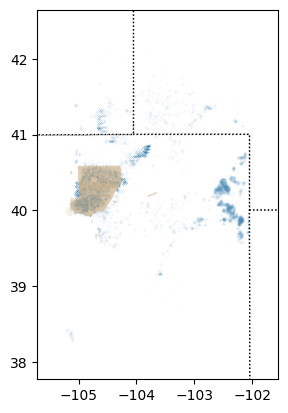

In [11]:
# Inputs for selected campaigns for the paper
campaignInputs = pd.DataFrame({'Scenario name': ['Permian_2019', 'Permian_2020', 'Permian_fall2021', 'Permian_summer2021', 'Cal_2016', 'Cal_2017', 'Cal_fall2020', 'Cal_summer2020', 'Cal_fall2021', 'Denver_summer2021', 'Denver_fall2021', 'Pennsylvania_2021', 'Utah_2020', 'Barnett_2021', 'Permian_2019_F2021_bounds', 'Permian_2019_F2021_bounds_Delaware', 'Permian_2019_F2021_Midland', 'Northeast Pennsylvania_2021', 'Permian_F2021_Delaware', 'Permian_F2021_Midland', 'Permian_2019_2024_flightlines', 'Permian_2019_2024_flightlines_inc_missing_radiance', 'CA_2016_full_fidelity_flightlines', 'CA_2017_full_fidelity_flightlines', 'CA_summer_2020_flightlines_full_fidelity'],
                              'Campaign name': ['Permian 2019 flightlines from unified 2024 dataset', 'Permian_2020', 'Permian_fall2021', 'Permian_summer2021', 'CA 2016 flightlines full fidelity 20240923', 'CA 2017 flightlines full fidelity 20240923', 'Cal_fall2020', 'CA summer 2020 flightlines full fidelity 20240923', 'Cal_fall2021', 'Denver_summer2021', 'Denver_fall2021', 'Northeast_2021', 'Utah_2020', 'Kairos', 'Permian 2019 flightlines from unified 2024 dataset', 'Permian 2019 flightlines from unified 2024 dataset', 'Permian 2019 flightlines from unified 2024 dataset', 'Northeast_2021', 'Permian_fall2021', 'Permian_fall2021', 'Permian 2019 flightlines from unified 2024 dataset', 'Permian 2019 flightlines from unified 2024 dataset including missing radiance', 'CA 2016 flightlines full fidelity 20240923', 'CA 2017 flightlines full fidelity 20240923', 'CA summer 2020 flightlines full fidelity 20240923'],
                              'Well data': ['Permian_2019_welldata.csv', 'Permian_2020_welldata.csv', 'Permian_2021_welldata.csv', 'Permian_2021_welldata.csv', 'CA_2016_welldata.csv', 'CA_2017_welldata.csv',  'CA_2020_welldata.csv', 'CA_2020_welldata.csv', 'CA_2021_welldata.csv', 'DJ_2021_welldata.csv', 'DJ_2021_welldata.csv', 'APP_2021_welldata.csv', 'UT_2020_welldata.csv', 'TX_2021_FW_welldata.csv', 'Permian_2019_welldata.csv', 'Permian_2019_welldata.csv', 'Permian_2019_welldata.csv', 'APP_2021_welldata.csv', 'Permian_2021_welldata.csv', 'Permian_2021_welldata.csv', 'Permian_2019_welldata.csv', 'Permian_2019_welldata.csv', 'CA_2016_welldata.csv', 'CA_2017_welldata.csv', 'CA_2020_welldata.csv'],
                              'Selected basin': ['Permian basin', 'Permian basin', 'Permian basin', 'Permian basin', 'San Joaquin basin', 'San Joaquin basin', 'San Joaquin basin', 'San Joaquin basin', 'San Joaquin basin', 'Denver basin', 'Denver basin', 'Appalachian basin (eastern overthrust area)', 'Uinta basin', 'Fort Worth syncline', 'Permian basin', 'Permian basin', 'Permian basin', 'Appalachian basin (eastern overthrust area)', 'Permian basin', 'Permian basin', 'Permian basin', 'Permian basin', 'San Joaquin basin', 'San Joaquin basin', 'San Joaquin basin'],
                              'State': [False, False, False, False, False, False, False, False, False, False, False, 'Pennsylvania', False, False, 'Permian_fall2021', 'Delaware_fall2021', 'Midland_fall2021', 'Northeast_Pennsylvania', 'Delaware_fall2021', 'Midland_fall2021', False, False, False, False, False],
                               'coveredwellsheetname': [False, False, False, False, False, False, False, False, False, False, False, False, False, 'StanfordPreciseBarnettProductionRequestFormatted_CorrectedCoverage_75NonO&GWellsRemovedGoodCols.csv', False, False, False, False, False, False, False, False, False, False, False]})

# Removing California 2016-2017 campaign for now , 'Cal_2016', 'Cal_2017'; , 'CA_2016_welldata.csv', 'CA_2017_welldata.csv'; , 'San Joaquin basin', 'San Joaquin basin'

# Create an index to run all selected campaigns
campaign_index_sequence = np.arange(0,25) #18 #20 # 22, # 24

# Run the first campaign outside the for loop
selected_campaign_index = campaign_index_sequence[0]
scenarioname = campaignInputs.loc[selected_campaign_index, 'Scenario name']
wellsheetname = campaignInputs.loc[selected_campaign_index, 'Well data'] # 'UT_2020_welldata.csv' 'CA_2017_welldata.csv'
campaignname = campaignInputs.loc[selected_campaign_index, 'Campaign name']# 'Utah_2020' 'Cal_201617'
selectBasin = campaignInputs.loc[selected_campaign_index, 'Selected basin']# 'Uinta basin' 'San Joaquin basin'
state = campaignInputs.loc[selected_campaign_index, 'State']# 'Pennsylvania'
coveredwellsheetname = campaignInputs.loc[selected_campaign_index, 'coveredwellsheetname']# 'StanfordPreciseBarnettProductionRequestFormatted.csv'
todaydate = '20250509'

# Compute summary stats and outputs for first campaign
slct_basin_campaign_summary_stats, covered_gas_prod_quantiles_by_well, covered_gas_prod_quantiles_by_visit, covered_oil_prod_quantiles, basin_gas_prod_quantiles, basin_oil_prod_quantiles, basin_oil_prod_quantiles_for_bottom_10pct_gas = distributionsSummaryStats(wellsheetname, campaignname, selectBasin, todaydate, scenarioname, state, coveredwellsheetname)
covered_gas_prod_quantiles_by_well = pd.DataFrame(covered_gas_prod_quantiles_by_well)
covered_gas_prod_quantiles_by_visit = pd.DataFrame(covered_gas_prod_quantiles_by_visit)
covered_oil_prod_quantiles = pd.DataFrame(covered_oil_prod_quantiles)
basin_gas_prod_quantiles = pd.DataFrame(basin_gas_prod_quantiles)
basin_oil_prod_quantiles = pd.DataFrame(basin_oil_prod_quantiles)
basin_oil_prod_quantiles_for_bottom_10pct_gas = pd.DataFrame(basin_oil_prod_quantiles_for_bottom_10pct_gas)

# Compute summary stats for remaining campaigns
for jj in campaign_index_sequence[1:]:
  scenarioname = campaignInputs.loc[jj, 'Scenario name']
  print(scenarioname)
  wellsheetname = campaignInputs.loc[jj, 'Well data'] # 'UT_2020_welldata.csv'
  campaignname = campaignInputs.loc[jj, 'Campaign name']# 'Utah_2020'
  selectBasin = campaignInputs.loc[jj, 'Selected basin']# 'Uinta basin'
  state = campaignInputs.loc[jj, 'State']
  coveredwellsheetname = campaignInputs.loc[jj, 'coveredwellsheetname']
  slct_basin_campaign_summary_stats_temp, covered_gas_prod_quantiles_by_well_temp, covered_gas_prod_quantiles_by_visit_temp, covered_oil_prod_quantiles_temp, basin_gas_prod_quantiles_temp, basin_oil_prod_quantiles_temp, basin_oil_prod_quantiles_for_bottom_10pct_gas_temp = distributionsSummaryStats(wellsheetname, campaignname, selectBasin, todaydate, scenarioname, state, coveredwellsheetname)
  slct_basin_campaign_summary_stats = pd.concat([slct_basin_campaign_summary_stats, slct_basin_campaign_summary_stats_temp], ignore_index=True)
  # slct_basin_campaign_summary_stats = slct_basin_campaign_summary_stats.append(slct_basin_campaign_summary_stats_temp, ignore_index=True)
  covered_gas_prod_quantiles_by_well[scenarioname] = covered_gas_prod_quantiles_by_well_temp
  covered_gas_prod_quantiles_by_visit[scenarioname] = covered_gas_prod_quantiles_by_visit_temp
  covered_oil_prod_quantiles[scenarioname] = covered_oil_prod_quantiles_temp
  basin_gas_prod_quantiles[scenarioname] = basin_gas_prod_quantiles_temp
  basin_oil_prod_quantiles[scenarioname] = basin_oil_prod_quantiles_temp
  basin_oil_prod_quantiles_for_bottom_10pct_gas[scenarioname] = basin_oil_prod_quantiles_for_bottom_10pct_gas_temp

# Save summary stats for all campaigns
slct_basin_campaign_summary_stats.to_csv(result_path + 'Summary_stats_all_basins_' + todaydate + '.csv', index=False)
covered_gas_prod_quantiles_by_well.to_csv(result_path + 'Covered_gas_prod_percentiles_all_basins_by_well' + todaydate + '.csv', index=False)
covered_gas_prod_quantiles_by_visit.to_csv(result_path + 'Covered_gas_prod_percentiles_all_basins_by_visit' + todaydate + '.csv', index=False)
covered_oil_prod_quantiles.to_csv(result_path + 'Covered_oil_prod_percentiles_all_basins_' + todaydate + '.csv', index=False)
basin_gas_prod_quantiles.to_csv(result_path + 'Basin_gas_prod_percentiles_all_basins_' + todaydate + '.csv', index=False)
basin_oil_prod_quantiles.to_csv(result_path + 'Basin_oil_prod_percentiles_all_basins_' + todaydate + '.csv', index=False)
basin_oil_prod_quantiles_for_bottom_10pct_gas.to_csv(result_path + 'Basin_oil_prod_percentiles_bottom_10pct_gas_all_basins_' + todaydate + '.csv', index=False)


# Compute source-level coverage by year for the Cal Methane 2016-2017 survey

In [21]:
# Select campaign
campaignname = 'CA 2017 flightlines full fidelity 20240923' # 'Cal_201617' 'Cal_2016' 'Cal_2017'  'CA 2016 flightlines full fidelity 20240923', 'CA 2017 flightlines full fidelity 20240923'
# root_path = '/content/drive/'
# shapedata_path = root_path + 'MyDrive/Distributionpaper/ShapefileData/'
campaign = gpd.GeoDataFrame.from_file(shapedata_path + campaignname + '.shp')
# campaign[["year", "month", "day"]] = campaign["datetime"].str.split("-", expand = True) # For original shapefiles
campaign[["year", "month", "day"]] = campaign["date"].str.split("-", expand = True) # for full-fidelity shapefiles

# Select Cal Methane survey source data frame
Duren_sources = pd.read_excel(root_path + 'CalMethaneData/' + 'Duren et al source stats 20220113.xlsx')
Duren_sources['count'] = 1
Duren_sources['Source identifier'].str.strip()
Duren_sources = cvt_point_to_geodf(Duren_sources, lonname='Source longitude (deg)', latname='Source latitude (deg)')

Duren_source_in_campaign = gpd.tools.sjoin(Duren_sources, campaign, predicate='within', how='inner')
Duren_source_in_campaign = Duren_source_in_campaign.sort_values(by=['Source identifier'])
Duren_source_in_campaign

Duren_source_in_campaign_groupby = Duren_source_in_campaign.groupby(['Source identifier']).agg({'Source identifier':'first', 'Source longitude (deg)': 'first', 'Source latitude (deg)': 'first', 'count': np.sum})
# Duren_source_in_campaign_groupby.to_csv(result_path + 'Duren_source_in_201617_campaign_20220911.csv', index=False)
# Duren_source_in_campaign_groupby.to_csv(result_path + 'Duren_source_in_2016_campaign_20220911.csv', index=False)
# Duren_source_in_campaign_groupby.to_csv(result_path + 'Duren_source_in_2017_campaign_20220911.csv', index=False)
# Duren_source_in_campaign_groupby.to_csv(result_path + 'Duren_source_in_2016_full_fidelity_campaign_20221001.csv', index=False)
Duren_source_in_campaign_groupby.to_csv(result_path + 'Duren_source_in_2017_full_fidelity_campaign_20221001.csv', index=False)
# Duren_source_in_campaign_groupby.head()

,Source identifier,Source longitude (deg),Source latitude (deg),count
Source identifier,,,,
S00006,S00006,-118.5883,34.4471,37
S00007,S00007,-118.4063,33.9060,10
S00008,S00008,-118.4064,33.9054,10
S00011,S00011,-118.2870,33.7770,6
S00012,S00012,-118.2864,33.7726,6


# Compute source-level coverage for other CM campaigns

In [22]:
# Select CM campaign (all except CA 2016/2017)
campaignnames = ['Permian 2019 flightlines from unified 2024 dataset', 'Permian_2020', 'Permian_fall2021', 'Permian_summer2021', 'Cal_fall2020', 'CA summer 2020 flightlines full fidelity 20240923', 'Cal_fall2021', 'Denver_summer2021', 'Denver_fall2021', 'Northeast_2021', 'Utah_2020']
# campaignnames = ['Permian 2019 flightlines from unified 2024 dataset including missing radiance', 'Permian_2020', 'Permian_fall2021', 'Permian_summer2021', 'Cal_fall2020', 'CA summer 2020 flightlines full fidelity 20240923', 'Cal_fall2021', 'Denver_summer2021', 'Denver_fall2021', 'Northeast_2021', 'Utah_2020']
# root_path = '/content/drive/'
# shapedata_path = root_path + 'MyDrive/Distributionpaper/ShapefileData/'

# Import all relevant CM sources
CM_sources = pd.read_excel(root_path + 'CalMethaneData/' + 'CarbonMapperPlumeSourceLists_2019-2021.xlsx', sheet_name='Source_List')
CM_sources['count'] = 1
# CM_sources['source_id'].str.strip()
CM_sources = cvt_point_to_geodf(CM_sources, lonname='source_lon', latname='source_lat')

# Initialize final output
CM_source_all_campaigns_groupby = pd.DataFrame(columns=['source_id',	'source_lon',	'source_lat',	'count'])

for campaignname in campaignnames:
  campaign = gpd.GeoDataFrame.from_file(shapedata_path + campaignname + '.shp')
  if ('Permian 2019' in campaignname):
    campaign[["year", "month", "day"]] = campaign["date"].str.split("-", expand = True)
  else:
    campaign[["year", "month", "day"]] = campaign["datetime"].astype(str).str.split("-", expand = True)
    # campaign[["year", "month", "day"]] = campaign["datetime"].str.split("-", expand = True)
  # Select CM survey source data frame
  if campaignname == 'Denver_summer2021':
    CM_sources_selected = CM_sources[CM_sources['source_id'].str.contains('A')]
  elif campaignname == 'Northeast_2021':
    CM_sources_selected = CM_sources[CM_sources['source_id'].str.contains('B')]
  elif campaignname == 'Permian_summer2021':
    CM_sources_selected = CM_sources[CM_sources['source_id'].str.contains('E')]
  elif campaignname == 'Permian_2020':
    CM_sources_selected = CM_sources[CM_sources['source_id'].str.contains('F')]
  elif campaignname == 'Utah_2020':
    CM_sources_selected = CM_sources[CM_sources['source_id'].str.contains('F')]
  elif campaignname == 'Cal_fall2020':
    CM_sources_selected = CM_sources[CM_sources['source_id'].str.contains('G')]
  elif (campaignname == 'Cal_summer2020') | ('CA summer 2020' in campaignname):
    CM_sources_selected = CM_sources[CM_sources['source_id'].str.contains('H')]
  elif (campaignname == 'Permian_2019') | ('Permian 2019' in campaignname):
    CM_sources_selected = CM_sources[CM_sources['source_id'].str.contains('P')]
  elif campaignname == 'Denver_fall2021':
    CM_sources_selected = CM_sources[CM_sources['source_id'].str.contains('I')]
  elif campaignname == 'Permian_fall2021':
    CM_sources_selected = CM_sources[CM_sources['source_id'].str.contains('J')]
  elif campaignname == 'Cal_fall2021':
    CM_sources_selected = CM_sources[CM_sources['source_id'].str.contains('K')]
  else: 1

  CM_source_in_campaign = gpd.tools.sjoin(CM_sources_selected,campaign,predicate='within',how='inner')
  CM_source_in_campaign = CM_source_in_campaign.sort_values(by=['source_id'])
  CM_source_in_campaign_groupby = CM_source_in_campaign.groupby(['source_id']).agg({'source_id':'first', 'source_lon': 'first', 'source_lat': 'first', 'count': np.sum})
  # Append all source coverage counts greater than zero to the master data frame
  CM_source_all_campaigns_groupby = pd.concat([CM_source_all_campaigns_groupby, CM_source_in_campaign_groupby.loc[CM_source_in_campaign_groupby['count']>0,:]], ignore_index=True)
# CM_source_all_campaigns_groupby.head()
# CM_source_all_campaigns_groupby.to_csv(result_path + 'CM_source_in_2019_2021_campaigns_20240930b.csv', index=False)
CM_source_all_campaigns_groupby.to_csv(result_path + 'CM_source_in_2019_2021_campaigns_inc_missing_radiance_20241001.csv', index=False)
# CM_source_all_campaigns_groupby

,source_id,source_lon,source_lat,count
0,P00001,-103.69721,32.212086,27
1,P00002,-103.67332,32.199937,23
2,P00003,-103.62658,32.116135,25
3,P00004,-103.81607,32.322594,12
4,P00005,-103.79392,32.284279,13
...,...,...,...,...
3822,F0501,-109.23505,40.076545,5
3823,F0502,-109.66830,40.117673,5
3824,F0503,-109.67924,40.161021,6
3825,F0504,-109.46544,40.165786,5


In [23]:
# Inspect resulting data frame
starting_point = 1
CM_source_all_campaigns_groupby.loc[starting_point:(starting_point+10), :]

,source_id,source_lon,source_lat,count
1,P00002,-103.67332,32.199937,23
2,P00003,-103.62658,32.116135,25
3,P00004,-103.81607,32.322594,12
4,P00005,-103.79392,32.284279,13
5,P00006,-102.81248,32.998981,11
6,P00007,-103.57077,32.027791,26
7,P00008,-103.81429,32.322764,12
8,P00009,-103.79800,32.273276,12
9,P00010,-103.77091,32.264258,13
10,P00011,-103.53618,31.912624,11


<Axes: >

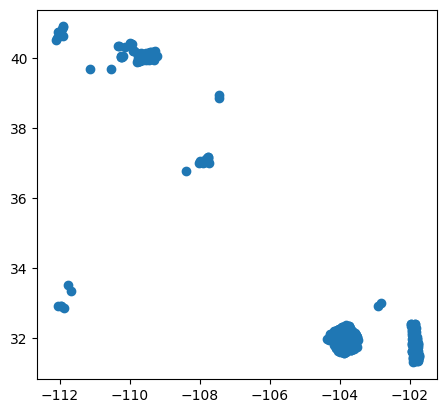

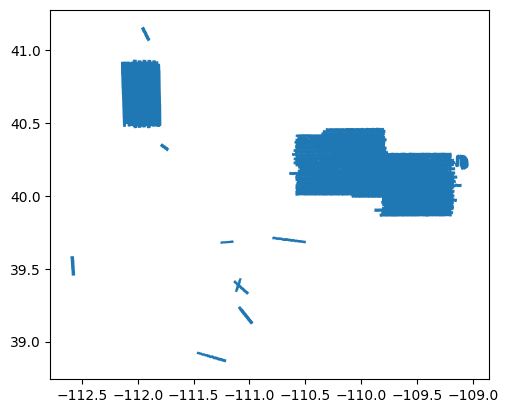

In [24]:
CM_sources_selected.plot()
campaign.plot()

# Permian flightlines by GAO/AVIRIS-NG

In [25]:
# Import necessary libraries
import re

In [26]:
# Import Permian 2019 flightlines by instrument (used in Chen et al. 2024)
Permian2019GAO = gpd.GeoDataFrame.from_file(shapedata_path + 'GAO_Methane_2019.shp')
Permian2019ANG = gpd.GeoDataFrame.from_file(shapedata_path + 'aviris_ng_polygons.shp')

In [27]:
# Import Permian 2019 flightlines used in Sherwin et al. 2024
Permian2019MM = gpd.GeoDataFrame.from_file(shapedata_path + 'Permian_2019.shp')

In [28]:
# Permian2019GAO['F']
Permian2019MM['flightline']

,flightline
0,ang20190922t165753
1,ang20190922t175159
2,ang20190922t180241
3,ang20190922t180922
4,ang20190922t182232
...,...
698,GAO20191104t174025p0000
699,GAO20191104t175326p0000
700,GAO20191104t180852p0000
701,GAO20191104t182132p0000


In [29]:
# Extract datetimes from Permian 2019 GAO data
Permian2019GAOdatetime = Permian2019GAO['FILE_NAME'].str.extract(r'(\d{8}).(\d{6})')
Permian2019GAOdatetime = Permian2019GAOdatetime[0].astype(str) + Permian2019GAOdatetime[1].astype(str)
Permian2019GAOdatetime

,0
0,20191009174419
1,20191009174704
2,20191010171502
3,20191010171502
4,20191010173507
...,...
356,20191104174025
357,20191104175326
358,20191104180852
359,20191104182132


In [30]:
# Extract datetimes from Permian 2019 ANG data
Permian2019ANGdatetime = Permian2019ANG['Name'].str.extract(r'(\d{8}).(\d{6})')
Permian2019ANGdatetime = Permian2019ANGdatetime[0].astype(str) + Permian2019ANGdatetime[1].astype(str)
Permian2019ANGdatetime

,0
0,20190921164213
1,20190921165138
2,20190921171752
3,20190921173549
4,20190921180042
...,...
403,20191027175950
404,20191027181503
405,20191027204454
406,20191027210505


In [31]:
# Extract datetimes from Permian 2019 GAO data from Million Measurements paper
Permian2019GAOMMdatetime = Permian2019MM.loc[Permian2019MM['platform']!='ang', 'flightline'].str.extract(r'(\d{8}).(\d{6})')
Permian2019GAOMMdatetime = Permian2019GAOMMdatetime[0].astype(str) + Permian2019GAOMMdatetime[1].astype(str)
Permian2019GAOMMdatetime

,0
355,20191010171502
356,20191010171502
357,20191010173507
358,20191010174934
359,20191010174934
...,...
698,20191104174025
699,20191104175326
700,20191104180852
701,20191104182132


In [32]:
# Extract datetimes from Permian 2019 ANG data from Million Measurements paper
Permian2019ANGMMdatetime = Permian2019MM.loc[Permian2019MM['platform']=='ang', 'flightline'].str.extract(r'(\d{8}).(\d{6})')
Permian2019ANGMMdatetime = Permian2019ANGMMdatetime[0].astype(str) + Permian2019ANGMMdatetime[1].astype(str)
Permian2019ANGMMdatetime

,0
0,20190922165753
1,20190922175159
2,20190922180241
3,20190922180922
4,20190922182232
...,...
350,20191025193513
351,20191025195446
352,20191025201220
353,20191025203400


In [33]:
# GAO flightlines not in both datasets
GAO_nonoverlapping_flightlines = set(Permian2019GAOdatetime) ^ set(Permian2019GAOMMdatetime)
GAO_nonoverlapping_flightlines

{'20191009174419',
 '20191009174704',
 '20191011152155',
 '20191011164930',
 '20191016152236',
 '20191016163836',
 '20191016184233',
 '20191026190328',
 '20191103151852',
 '20191103153107',
 '20191103174217',
 '20191103175512',
 '20191103181042'}

In [34]:
# ANG flightlines not in both datasets
ANG_nonoverlapping_flightlines = set(Permian2019ANGdatetime) ^ set(Permian2019ANGMMdatetime)
ANG_nonoverlapping_flightlines

{'20190921164213',
 '20190921165138',
 '20190921171752',
 '20190921173549',
 '20190921180042',
 '20190921181553',
 '20191001154018',
 '20191001163521',
 '20191003161326',
 '20191003162200',
 '20191003163057',
 '20191003164015',
 '20191003164906',
 '20191003165820',
 '20191003171534',
 '20191003172628',
 '20191003173553',
 '20191003174609',
 '20191003175539',
 '20191003183544',
 '20191003184025',
 '20191003184549',
 '20191004171247',
 '20191004173900',
 '20191004183104',
 '20191004184130',
 '20191004185054',
 '20191004191953',
 '20191004192550',
 '20191004193113',
 '20191004193658',
 '20191004194846',
 '20191004200111',
 '20191004201341',
 '20191004202604',
 '20191004203826',
 '20191004205050',
 '20191004210456',
 '20191004212258',
 '20191004213814',
 '20191004215336',
 '20191004221515',
 '20191027153111',
 '20191027153848',
 '20191027160833',
 '20191027162115',
 '20191027170931',
 '20191027173643',
 '20191027175950',
 '20191027181503',
 '20191027204454',
 '20191027210505',
 '2019102721

<Axes: >

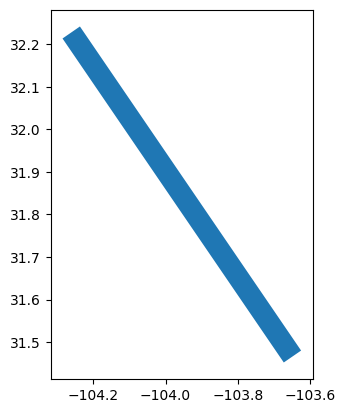

In [35]:
# Outline of flightline with a plume but missing radiance in the 2024 dataset
Permian2019MM[Permian2019MM['flightline']=='ang20190926t171159'].plot()
# Permian2019MM[Permian2019MM['flightline']=='ang20190922t180922'].plot() # Confirmation that ANG flightlines are bounding boxes
# Permian2019MM[Permian2019MM['flightline']=='GAO20191104t175326p0000'].plot() # Confirmation that GAO flightlines are actual flight polygons

# Count flight days by CM campaign

In [36]:
campaignname = ['Permian_2019', 'Permian_2020', 'Permian_fall2021', 'Permian_summer2021', 'Cal_2016', 'Cal_2017', 'Cal_fall2020', 'Cal_summer2020', 'Cal_fall2021', 'Denver_summer2021', 'Denver_fall2021', 'Northeast_2021', 'Utah_2020']
campaign_days = pd.DataFrame(campaignname)
campaign_days['days'] = 0
hours_data_per_day = 4
for jj in np.arange(len(campaignname)):
  campaign = gpd.GeoDataFrame.from_file(shapedata_path + campaignname[jj] + '.shp')
  campaign_days.loc[jj, 'days'] = len(campaign.date.unique())

campaign_days['hours'] = campaign_days['days']*hours_data_per_day
campaign_days

,0,days,hours
0,Permian_2019,31,124
1,Permian_2020,9,36
2,Permian_fall2021,14,56
3,Permian_summer2021,13,52
4,Cal_2016,25,100
5,Cal_2017,46,184
6,Cal_fall2020,15,60
7,Cal_summer2020,22,88
8,Cal_fall2021,8,32
9,Denver_summer2021,8,32


# MethaneAIR coverage analysis

<Axes: >

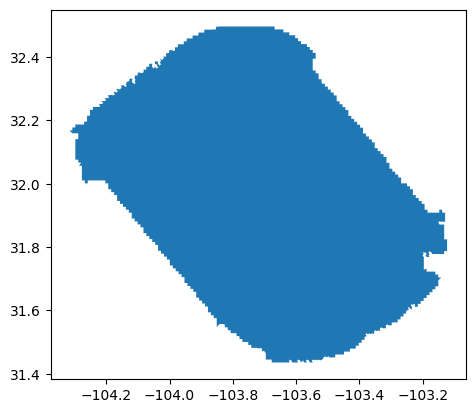

In [37]:
# Import MAIR shapefile
# Permian:'GIM_Domain_RF06.shp', Uinta: 'GIM_Domain_RF08_Uinta.shp', 'GIM_Domain_RF08_SLC.shp'
mair_shapefile = gpd.GeoDataFrame.from_file(shapedata_path + 'GIM_Domain_RF06.shp')
mair_shapefile.plot()

In [38]:
# Import wells in the selected basin

wellsheetname = 'Permian_2021_welldata.csv' # 'Permian_2021_welldata.csv', 'UT_2020_welldata.csv'
wells = pd.read_csv(welldata_path + wellsheetname)
wells = cvt_point_to_geodf(wells, lonname='Surface Hole Longitude (WGS84)', latname='Surface Hole Latitude (WGS84)')
  # Add daily average oil and gas production columns
wells = generateAvgOilGasProd(wells)
wells_covered_by_MAIR = gpd.tools.sjoin(wells,mair_shapefile,predicate='within',how='inner').drop('index_right', axis=1)
wells_covered_by_MAIR.shape, wells.shape

((12572, 31), (337360, 30))

In [39]:
# Count wells covered by MAIR that have nonzero gas or oil production at some point in 2021
oil_prod_monthly_cols = ['Oil_01', 'Oil_02', 'Oil_03', 'Oil_04', 'Oil_05', 'Oil_06', 'Oil_07', 'Oil_08', 'Oil_09', 'Oil_10', 'Oil_11', 'Oil_12']
gas_prod_monthly_cols = ['Gas_01', 'Gas_02', 'Gas_03', 'Gas_04', 'Gas_05', 'Gas_06', 'Gas_07', 'Gas_08', 'Gas_09', 'Gas_10', 'Gas_11', 'Gas_12']
producing_wells_covered_by_MAIR = wells_covered_by_MAIR.loc[wells_covered_by_MAIR.loc[:, gas_prod_monthly_cols].sum(axis=1) >0, :] # oil_prod_monthly_cols + gas_prod_monthly_cols
producing_wells_covered_by_MAIR.shape
# wells_covered_by_MAIR.loc[:, oil_prod_monthly_cols + gas_prod_monthly_cols].sum(axis=1) >0

(11688, 31)

In [40]:
# Production covered by MAIR
covered_gas_prod_mcf_month = wells_covered_by_MAIR['Gas_08'].sum()
days_in_August = 30
covered_gas_prod_mcfd = covered_gas_prod_mcf_month/days_in_August
covered_gas_prod_mcfd

np.float64(7700744.9)

In [41]:
# Annual average production from wells covered by MAIR
covered_gas_prod_mcf_annual = (wells_covered_by_MAIR['Gas_01'] + wells_covered_by_MAIR['Gas_02'] + wells_covered_by_MAIR['Gas_03'] +
                              wells_covered_by_MAIR['Gas_04'] + wells_covered_by_MAIR['Gas_05'] + wells_covered_by_MAIR['Gas_06'] +
                              wells_covered_by_MAIR['Gas_07'] + wells_covered_by_MAIR['Gas_08'] + wells_covered_by_MAIR['Gas_09'] +
                              wells_covered_by_MAIR['Gas_10'] + wells_covered_by_MAIR['Gas_11'] + wells_covered_by_MAIR['Gas_12']).sum()
days_per_nonleap_year = 365
covered_gas_prod_annual_mcfd = covered_gas_prod_mcf_annual/days_per_nonleap_year
covered_gas_prod_annual_mcfd

np.float64(7140883.04109589)

(<Axes: >, <Axes: >)

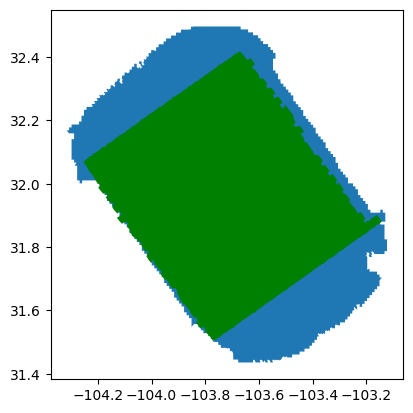

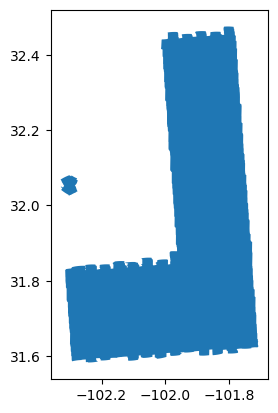

In [42]:
# Carbon Mapper Permian 2021 survey, Delaware only
CM_Permian2021_shapefile = gpd.GeoDataFrame.from_file(shapedata_path + 'Permian_summer2021' + '.shp')
ymin, ymax, xmin, xmax = 0, 90, -110, -103
delaware_selection_box = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)])
CM2021_delaware_only = gpd.clip(CM_Permian2021_shapefile, delaware_selection_box).dissolve()
ymin, ymax, xmin, xmax = 0, 90, -103, -99
midland_selection_box = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)])
CM2021_midland_only = gpd.clip(CM_Permian2021_shapefile, midland_selection_box).dissolve()
campaign_plot, ax = plt.subplots()
mair_shapefile.plot(ax=ax)
CM2021_delaware_only.plot(ax=ax, color='green'), CM2021_midland_only.plot()

In [43]:
# August production in the CM Permian Delaware summer 2021 campaign (there were also some flight days in July)
wells_covered_by_CMS21 = gpd.tools.sjoin(wells,CM2021_delaware_only,predicate='within',how='inner').drop('index_right', axis=1)
covered_gas_prod_mcf_month = wells_covered_by_CMS21['Gas_08'].sum()
days_in_August = 30
covered_gas_prod_mcfd_CMS21_delaware = covered_gas_prod_mcf_month/days_in_August
covered_gas_prod_mcfd_CMS21_delaware

np.float64(6365801.866666666)

In [44]:
# August production in the CM Permian Midland summer 2021 campaign (there were also some flight days in July)
wells_covered_by_CMS21 = gpd.tools.sjoin(wells,CM2021_midland_only,predicate='within',how='inner').drop('index_right', axis=1)
covered_gas_prod_mcf_month = wells_covered_by_CMS21['Gas_08'].sum()
days_in_August = 30
covered_gas_prod_mcfd_CMS21_midland = covered_gas_prod_mcf_month/days_in_August
covered_gas_prod_mcfd_CMS21_midland

np.float64(2251246.3666666667)

In [45]:
wells_covered_by_CMS21.shape

(9750, 38)

# CM Permian flightline intercomparison

In [46]:
# Save flightline IDs and dates to CSV file
Permian2019MM = gpd.GeoDataFrame.from_file(shapedata_path + 'Permian_2019' + '.shp')

# Drop 'P000#' from GAO scene IDs
Permian2019MM['flightline'] = (Permian2019MM['flightline'].str.split('p', expand=True)).iloc[:,0]

# Permian2019MM.loc[:, ['flightline', 'date', 'datetime', 'platform']].to_csv(result_path + 'Permian 2019 flightline IDs' + '.csv', index=False)

In [47]:
# Read Carbon Mapper Permian flightlines
Permian_flightlines_2024 = gpd.read_file(shapedata_path + 'scenes_permian_published_20240510.gpkg')

# Drop 'P000#' from GAO scene IDs
Permian_flightlines_2024['scene_id'] = (Permian_flightlines_2024['scene_id'].str.split('p', expand=True)).iloc[:,0]
# Permian_flightlines_2024
# Permian_flightlines.loc[:, ['id', 'scene_id', 'public', 'published_plume_count', 'timestamp',
#        'created', 'instrument', 'not_cloudy', 'assessment_status', 'note',
#        'atmospheric_artifacts', 'geolocation_error', 'image_artifacts',
#        'low_snr', 'cloud_cover_pct']].to_csv(result_path + 'Permian 2016+ flightline IDs.csv')

<Axes: >

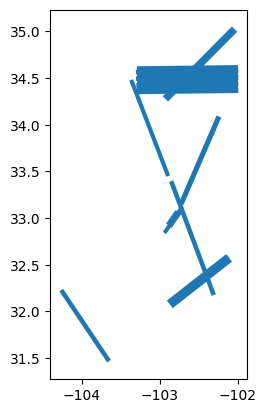

In [48]:
# Read in additional Carbon Mapper Permian flightlines pulled in 2024 that are north of the original query
# And scenes with flight irregular outlines that were initially represented as bounding boxes in the Million Measurements dataset
Permian_flightlines_2024_north = gpd.read_file(shapedata_path + '8_scenes_north_of_permian_in_mm_not_2024.geojson')
Permian_flightlines_2024_irregular = gpd.read_file(shapedata_path + 'missing_scenes_geoms.geojson')
Permian_flightlines_2024_not_MM = pd.read_csv(shapedata_path + 'Permian flightlines in 2024 dataset and not in MM.csv')
# Flightlines that are in the Million Measurements dataset but do not have radiance listed in the 2024 dataset (all but the last of these has not plumes detected)
Permian_flightlines_MM_no_radiance_2024_list = ['ang20191007t161542', 'ang20191007t164040', 'ang20191007t165731', 'ang20191007t171107',
                                           'ang20191007t171816', 'ang20191007t173338', 'ang20191012t165958', 'ang20191012t171542',
                                           'ang20191012t174021', 'ang20191012t175609', 'ang20191012t182032', 'ang20191012t183602',
                                           'ang20191012t190016', 'ang20191012t191600', 'ang20191012t194024', 'ang20191012t195745',
                                           'ang20190926t171159']
Permian_flightlines_MM_no_radiance_2024 = Permian2019MM[Permian2019MM['flightline'].isin(Permian_flightlines_MM_no_radiance_2024_list)].reset_index(drop=True)
# Permian_flightlines_2024_north
# Permian_flightlines_2024_irregular
# Permian_flightlines_2024_not_MM
Permian_flightlines_MM_no_radiance_2024.plot()

In [49]:
# Create unified 2019 Permian flightlines generated in 2024
Permian_flightlines_2024_full = gpd.read_file(shapedata_path + 'scenes_permian_published_20240510.gpkg') # Refrain from dropping the P000# from the GAO flightlines
Permian_flightlines_2024_full = Permian_flightlines_2024_full[Permian_flightlines_2024_full['instrument'].isin(['GAO', 'ang'])] # Extract only GAO and ANG flightlines
Permian_flightlines_2024_full = Permian_flightlines_2024_full[Permian_flightlines_2024_full['timestamp'].dt.year == 2019] # Include only 2019 flightlines
Permian_flightlines_2024_full['date'] = Permian_flightlines_2024_full['timestamp'].dt.date

Permian_flightlines_2024_full['flightline'] = Permian_flightlines_2024_full['scene_id']
Permian_flightlines_2024_north['date'] = pd.to_datetime(Permian_flightlines_2024_north['date'])
Permian_flightlines_2024_irregular_full = Permian2019MM[Permian2019MM['flightline'].isin(Permian_flightlines_2024_irregular['scene_id'])].reset_index(drop=True) # Pull full metadata for irregular flightlines
Permian_flightlines_2024_irregular_full['geometry'] = Permian_flightlines_2024_irregular['geometry'] # Add the correct geometry for irregular flightlines

Permian_flightlines_2024_full.columns, Permian_flightlines_2024_north.columns, Permian_flightlines_2024_irregular_full.columns, Permian2019MM.columns

(Index(['id', 'scene_id', 'public', 'published_plume_count', 'timestamp',
        'created', 'instrument', 'not_cloudy', 'assessment_status', 'note',
        'atmospheric_artifacts', 'geolocation_error', 'image_artifacts',
        'low_snr', 'cloud_cover_pct', 'geometry', 'date', 'flightline'],
       dtype='object'),
 Index(['fid', 'id', 'scene_id', 'public', 'published_plume_count', 'timestamp',
        'created', 'instrument', 'not_cloudy', 'assessment_status', 'note',
        'atmospheric_artifacts', 'geolocation_error', 'image_artifacts',
        'low_snr', 'cloud_cover_pct', 'queryable_datetime', 'flightline',
        'date', 'datetime', 'platform', 'OBJECTID', 'flightline_2', 'date_2',
        'datetime_2', 'platform_2', 'campaign', 'Shape_Leng', 'Shape_Area',
        'geometry'],
       dtype='object'),
 Index(['OBJECTID', 'flightline', 'date', 'datetime', 'platform', 'campaign',
        'Shape_Leng', 'Shape_Area', 'geometry'],
       dtype='object'),
 Index(['OBJECTID', 'fligh

In [50]:
unified_2019_flightline_columns = ['flightline', 'date', 'geometry']
unified_Permian_2019_flightlines = pd.concat([pd.concat([Permian_flightlines_2024_full[unified_2019_flightline_columns],
                                              Permian_flightlines_2024_north[unified_2019_flightline_columns]], axis=0),
                                              Permian_flightlines_2024_irregular_full[unified_2019_flightline_columns]], axis=0)

unified_Permian_2019_flightlines_including_no_radiance = pd.concat([unified_Permian_2019_flightlines, Permian_flightlines_MM_no_radiance_2024[unified_2019_flightline_columns]],
                                                                   axis=0)

unified_Permian_2019_flightlines['date'] = unified_Permian_2019_flightlines['date'].astype(str) # Convert 'date' to object to enable GeoJSON save
unified_Permian_2019_flightlines_including_no_radiance['date'] = unified_Permian_2019_flightlines_including_no_radiance['date'].astype(str)

# unified_Permian_2019_flightlines.dtypes
# Save both versions of unified Permian 2019 flightlines as a shapefile
unified_Permian_2019_flightlines.to_file(shapedata_path + 'Permian 2019 flightlines from unified 2024 dataset.shp', driver='ESRI Shapefile')
unified_Permian_2019_flightlines_including_no_radiance.to_file(shapedata_path + 'Permian 2019 flightlines from unified 2024 dataset including missing radiance.shp', driver='ESRI Shapefile')

# unified_Permian_2019_flightlines.plot()

# Permian_flightlines_2024_irregular_full.plot()
# Permian_flightlines_2024_irregular['geometry']
# Permian_flightlines_2024_irregular_full['geometry']
# pd.to_datetime(Permian_flightlines_2024_north['date'])
# Permian_flightlines_2024_full.head()['timestamp'].dt.date
# Permian2019MM['date']

,flightline,date,geometry
1333,GAO20191104t183633p0000,2019-11-04,"POLYGON ((-104.54001 33.05042, -104.53937 33.0..."
1334,GAO20191104t182132p0000,2019-11-04,"POLYGON ((-104.5235 33.03715, -104.52286 33.03..."
1335,GAO20191104t180852p0000,2019-11-04,"POLYGON ((-104.48581 33.03343, -104.48516 33.0..."
1336,GAO20191104t175326p0000,2019-11-04,"POLYGON ((-104.48717 33.00832, -104.48652 33.0..."
1337,GAO20191104t174025p0000,2019-11-04,"POLYGON ((-104.47832 32.98447, -104.47767 32.9..."


In [51]:
Permian_flightlines_2024_unified_imported = gpd.read_file(shapedata_path + 'Permian 2019 flightlines from unified 2024 dataset.shp')
# Permian_flightlines_2024_unified_imported = gpd.read_file(shapedata_path + 'Permian 2019 flightlines from unified 2024 dataset including missing radiance.shp')
# Permian_flightlines_2024_unified_imported.plot()
Permian_flightlines_2024_unified_imported.shape

(700, 3)

<Axes: >

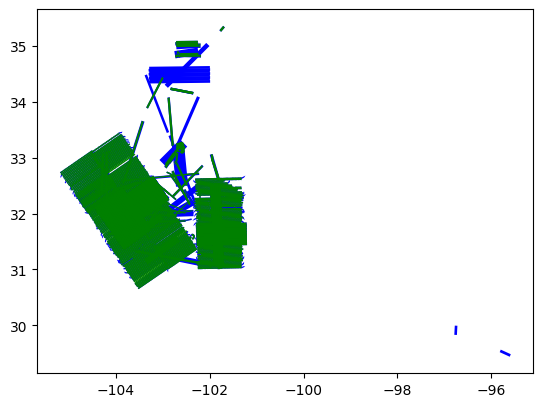

In [52]:
# Plot original Million Measurements Permian 2019 dataset v. unified version generated in 2024
Permian_2019_flightline_comparison, ax = plt.subplots()
Permian2019MM.plot(color='blue', ax=ax)
Permian_flightlines_2024_unified_imported.plot(color='green', ax=ax)

In [53]:
# Flightlines in Million Measurements dataset not in unified dataset
# Removes p0000 from GAO flightline names
Permian_flightlines_unified_GAO_names_harmonized = Permian_flightlines_2024_unified_imported['flightline'].str.split('p', expand=True).iloc[:,0]
Permian2019MM_not_in_unified = Permian2019MM.loc[Permian2019MM['flightline'].isin(Permian_flightlines_unified_GAO_names_harmonized)==False, :]
Permian2019unified_not_in_MM = Permian_flightlines_unified_GAO_names_harmonized.loc[Permian_flightlines_unified_GAO_names_harmonized.isin(Permian2019MM['flightline'])==False]
Permian2019MM_not_in_unified.shape, Permian2019unified_not_in_MM.shape

((19, 9), (20,))

(34.75, 36.0)

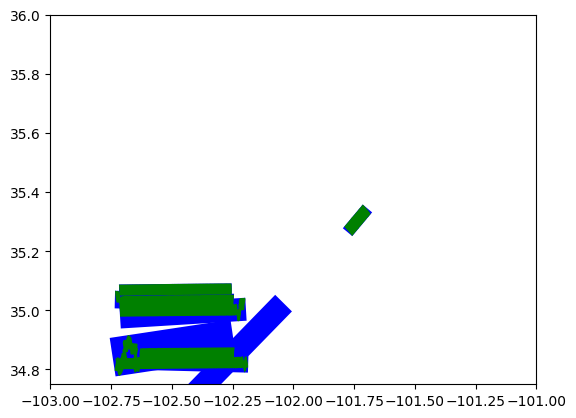

In [54]:
# Plot irregular flightline outlines v. bounding boxes
Permian_2019_northern_flightline_comparison, ax = plt.subplots()
Permian2019MM.plot(color='blue', ax=ax)
Permian_flightlines_2024_north.plot(color='green', ax=ax)
ax.set_xlim(-103, -101)
ax.set_ylim(34.75, 36)

<Axes: >

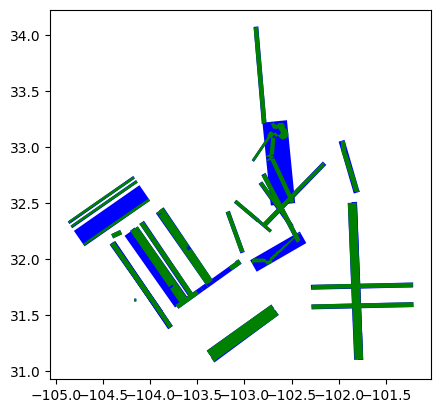

In [55]:
# Plot northern flightlines from MM v. 2024 dataset
Permian_2019_irregular_flightline_comparison, ax = plt.subplots()
Permian_2019_irregular_bounding_boxes = Permian2019MM[Permian2019MM['flightline'].isin(Permian_flightlines_2024_irregular['scene_id'])].reset_index(drop=True) # Pull full metadata for irregular flightlines
Permian_2019_irregular_bounding_boxes.plot(color='blue', ax=ax)
Permian_flightlines_2024_irregular_full.plot(color='green', ax=ax)

In [56]:

# re.split("p", Permian_flightlines_2024['scene_id'])
# for jj in Permian_flightlines_2024['scene_id']:
#   jj.split('p')
#   jj

# (Permian_flightlines_2024['scene_id'].str.split('p', expand=True)).iloc[:,0]
# Permian_flightlines_2024['scene_id'].head()
Permian2019MM['flightline'].head()

,flightline
0,ang20190922t165753
1,ang20190922t175159
2,ang20190922t180241
3,ang20190922t180922
4,ang20190922t182232


<Axes: >

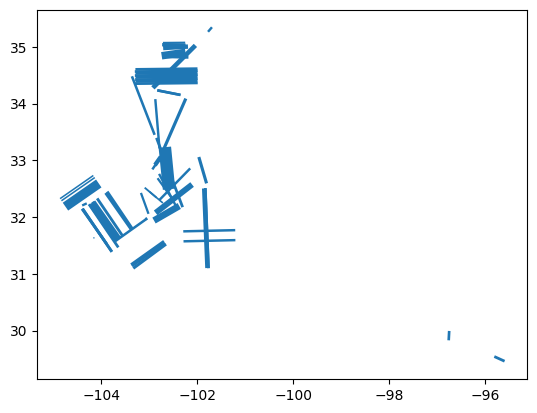

In [57]:
# In MM and not in 2024 dataset
# Permian_flightlines_2024.plot()
Permian2019MM_notinnewdataset = Permian2019MM.loc[Permian2019MM['flightline'].isin(Permian_flightlines_2024['scene_id'])==False, :]
# Permian2019MM_notinnewdataset.shape
Permian2019MM_notinnewdataset.plot()
# Permian2019MM_notinnewdataset.iloc[np.arange(5),:].plot()
# Permian2019MM_notinnewdataset.loc[:, ["OBJECTID", "flightline", "date", "datetime", "platform", "campaign", "Shape_Leng", "Shape_Area"]].to_csv(result_path + 'Permian flightlines in MM and not 2024 dataset.csv', index=False)

<Axes: >

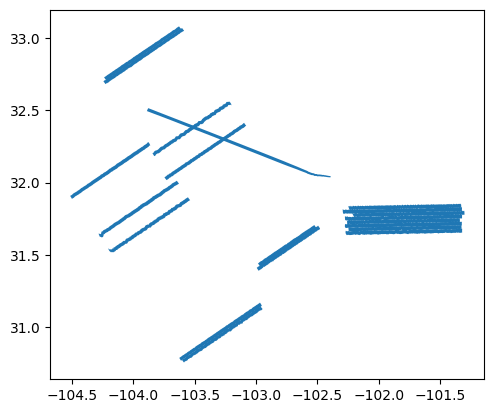

In [58]:
Permiannew_notinPermian2019MM = Permian_flightlines_2024.loc[(Permian_flightlines_2024['scene_id'].isin(Permian2019MM['flightline'])==False) & (pd.DatetimeIndex(Permian_flightlines_2024['timestamp']).year==2019), :]
Permiannew_notinPermian2019MM.plot()
# Permiannew_notinPermian2019MM.shape
# Permian2019MM_notinnewdataset = Permian2019MM.loc[(Permian2019MM['flightline'].isin(Permian_flightlines_2024['scene_id'])==False) * (pd.DatetimeIndex(Permian_flightlines_2024['timestamp']).year==2019), :]
# Permiannew_notinPermian2019MM.loc[(Permiannew_notinPermian2019MM["published_plume_count"]==0), :].plot()
# Permiannew_notinPermian2019MM.loc[:, ["id", "scene_id", "public", "published_plume_count", "timestamp", "created", "instrument", "not_cloudy", "assessment_status", "note", "atmospheric_artifacts", "geolocation_error", "image_artifacts", "low_snr", "cloud_cover_pct"]].to_csv(result_path + 'Permian flightlines in 2024 dataset and not in MM.csv', index=False)

In [59]:
Permiannew_inPermian2019MM = Permian_flightlines_2024.loc[Permian_flightlines_2024['scene_id'].isin(Permian2019MM['flightline']), :]
Permiannew_inPermian2019MM.shape
# Permiannew_inPermian2019MM.plot()

(638, 16)

<Axes: >

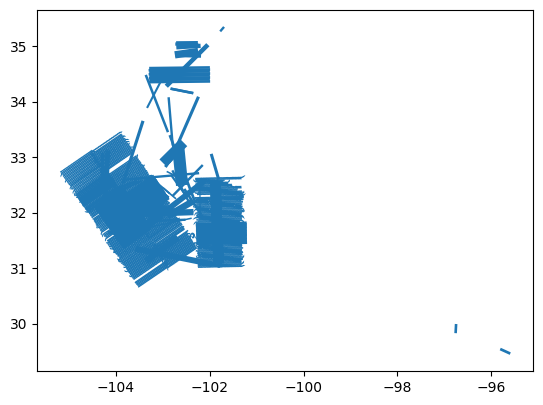

In [60]:
Permian2019MM_inPermiannew = Permian2019MM.loc[Permian2019MM['flightline'].isin(Permian_flightlines_2024['scene_id']), :]
# Permian2019MM_inPermiannew.shape
Permian2019MM.plot()

In [ ]:
# Load Carbon Mapper plumes
CM_plumes_MM = pd.read_excel(root_path + 'MyDrive/Distributionpaper/CalMethaneData/' + 'CarbonMapperPlumeSourceLists_2019-2021.xlsx', sheet_name='Plume_List')
CM_plumes_MM_Permian = CM_plumes_MM[CM_plumes_MM['source_id'].str.contains('P')]
CM_plumes_MM_Permian

,source_id,plume_lat,plume_lon,candidate_id,date_of_detection,time_of_detection,source_type,ipcc,qplume,sigma_qplume
0,P00001,32.212063,-103.69708,ang20190922t192642-2,2019-09-22,19:26:42,tank,1B2 Oil & Natural Gas,2579.528100,902.732655
1,P00002,32.200072,-103.67330,ang20190922t192642-4,2019-09-22,19:26:42,tank,1B2 Oil & Natural Gas,420.725207,147.155782
2,P00003,32.116008,-103.62635,ang20190922t192642-5,2019-09-22,19:26:42,tank,1B2 Oil & Natural Gas,1051.909600,339.267587
3,P00004,32.322594,-103.81607,ang20190922t194340-1,2019-09-22,19:43:40,pipeline,1B2 Oil & Natural Gas,1736.644250,1035.427670
4,P00005,32.284083,-103.79399,ang20190922t194340-2,2019-09-22,19:43:40,tank,1B2 Oil & Natural Gas,870.605019,435.968147
...,...,...,...,...,...,...,...,...,...,...
3062,P01795,32.777299,-104.28021,GAO20191103t185130p0000-B,2019-11-03,18:51:30,tank,1B2 Oil & Natural Gas,244.219726,137.743427
3063,P01796,32.888250,-104.11992,GAO20191103t190631p0000-A,2019-11-03,19:06:31,pipeline,1B2 Oil & Natural Gas,185.375804,55.152132
3064,P01797,32.884300,-104.12329,GAO20191103t190631p0000-B,2019-11-03,19:06:31,pipeline,1B2 Oil & Natural Gas,237.801830,63.544748
3065,P01795,32.777258,-104.27985,GAO20191103t190631p0000-C,2019-11-03,19:06:31,tank,1B2 Oil & Natural Gas,282.037503,117.607741


In [ ]:
# Find plumes associated with scenes not present in new Permian scene database
CM_plumes_MM_Permian['scene_id'] = (CM_plumes_MM_Permian['candidate_id'].str.split('-', expand=True)).iloc[:,0]
CM_plumes_MM_Permian['scene_id'] = (CM_plumes_MM_Permian['scene_id'].str.split('p', expand=True)).iloc[:,0]
plumes_notin_new = CM_plumes_MM_Permian.loc[CM_plumes_MM_Permian['scene_id'].isin(Permian2019MM_notinnewdataset['flightline']), :]
plumes_in_scenes_missing_in_new = CM_plumes_MM_Permian.loc[CM_plumes_MM_Permian['scene_id'].isin(selected_plumes['scene_id']), :]
scenes_with_plumes_MM_not_new = Permian2019MM_notinnewdataset.loc[Permian2019MM_notinnewdataset['flightline'].isin(plumes_in_scenes_missing_in_new['scene_id']), :]
Permian2019MM_notinnewdataset['flightline']
# scenes_with_plumes_MM_not_new
# plumes_notin_new.shape
# plumes_in_scenes_missing_in_new['scene_id']
# Permian2019MM_notinnewdataset


# scenes_with_plumes_MM_not_new.to_csv(result_path + 'Permian flightlines in MM and not new dataset with plumes.csv', index=False)

# Permian2019MM_notinnewdataset['flightline']
# CM_plumes_MM_Permian['scene_id']

(26,)

In [ ]:
# 2019 QC dataset Dan sent
Permian_flightlines_qc = pd.read_excel(shapedata_path + 'permian_qc.xlsx')
Permian_flightlines_2019_qc = Permian_flightlines_qc.loc[Permian_flightlines_qc['Flight Run'].str.contains('GAO2019') | Permian_flightlines_qc['Flight Run'].str.contains('ang2019'), :]
# Drop the extra "p000#"
Permian_flightlines_2019_qc['scene_id'] = Permian_flightlines_2019_qc['Flight Run'].str.split('p', expand=True).iloc[:,0]
Permian_flightlines_2019_qc

,Flight Run,Notes,scene_id
0,GAO20191010t145854p0000,NaN,GAO20191010t145854
1,GAO20191010t151827p0000,NaN,GAO20191010t151827
2,GAO20191010t153310p0000,NaN,GAO20191010t153310
3,GAO20191010t155244p0000,NaN,GAO20191010t155244
4,GAO20191010t160715p0000,NaN,GAO20191010t160715
...,...,...,...
719,ang20191025t193513,NaN,ang20191025t193513
720,ang20191025t195446,NaN,ang20191025t195446
721,ang20191025t201220,NaN,ang20191025t201220
722,ang20191025t203400,NaN,ang20191025t203400


In [ ]:
# Find scenes in the Million Measurements paper that are not in the QC dataset
Permian2019MM_notinnewdataset = Permian2019MM.loc[Permian2019MM['flightline'].isin(Permian_flightlines_2019_qc['scene_id'])==False, :]
# Permian2019MM_notinnewdataset.shape
# Permian2019MM_notinnewdataset.plot()
# Permian2019MM_notinnewdataset
Permian2019MM_notinnewdataset

,OBJECTID,flightline,date,datetime,platform,campaign,Shape_Leng,Shape_Area,geometry
0,1,ang20190922t165753,2019-09-22,2019-09-22T16:57:53Z,ang,Permian_2019,1.043559,0.013855,"POLYGON ((-102.21909 31.93429, -102.22435 32.4..."
1,2,ang20190922t175159,2019-09-22,2019-09-22T17:51:59Z,ang,Permian_2019,1.003838,0.017657,"POLYGON ((-102.71800 35.08763, -102.25406 35.0..."
2,3,ang20190922t180241,2019-09-22,2019-09-22T18:02:41Z,ang,Permian_2019,1.098308,0.029178,"POLYGON ((-102.24653 34.99662, -102.73580 35.0..."
3,4,ang20190922t180922,2019-09-22,2019-09-22T18:09:22Z,ang,Permian_2019,1.193218,0.040354,"POLYGON ((-102.71666 35.01625, -102.19828 35.0..."
4,5,ang20190922t182232,2019-09-22,2019-09-22T18:22:32Z,ang,Permian_2019,1.265792,0.066103,"POLYGON ((-102.75627 34.90673, -102.25905 34.9..."
5,6,ang20190922t182930,2019-09-22,2019-09-22T18:29:30Z,ang,Permian_2019,1.203853,0.030500,"POLYGON ((-102.18724 34.78941, -102.73300 34.8..."
82,83,ang20191005t184853,2019-10-05,2019-10-05T18:48:53Z,ang,Permian_2019,0.559669,0.011510,"POLYGON ((-95.60165 29.43913, -95.81589 29.521..."
83,84,ang20191005t190910,2019-10-05,2019-10-05T19:09:10Z,ang,Permian_2019,0.441966,0.009220,"POLYGON ((-96.78408 29.83100, -96.77380 29.995..."
104,105,ang20191007t160856,2019-10-07,2019-10-07T16:08:56Z,ang,Permian_2019,0.323146,0.005285,"POLYGON ((-101.79661 35.27771, -101.71483 35.3..."
105,106,ang20191007t161542,2019-10-07,2019-10-07T16:15:42Z,ang,Permian_2019,2.497455,0.101187,"POLYGON ((-102.96196 34.30471, -102.07508 35.0..."


In [ ]:
# Plumes in the MM scenes missing in the QC dataset
plumes_in_scenes_missing_in_new = CM_plumes_MM_Permian.loc[CM_plumes_MM_Permian['scene_id'].isin(Permian2019MM_notinnewdataset['flightline']), :]
plumes_in_scenes_missing_in_new['scene_id'].unique()

array([], dtype=object)

In [ ]:
# Find scenes in the new scene dataset that are not in the QC dataset
Permian2019new_notin_qc = Permian_flightlines_2024.loc[(Permian_flightlines_2024['scene_id'].isin(Permian_flightlines_2019_qc['scene_id'])==False) & (pd.DatetimeIndex(Permian_flightlines_2024['timestamp']).year==2019), :]
Permian2019new_notin_qc
# Permian2019new_notin_qc.to_csv(result_path + 'Permian flightlines in 2024 dataset and not QC.csv', index=False)

In [ ]:
# Find scenes in the QC dataset that are not in the new scene dataset
Permianqc_notin_new = Permian_flightlines_2019_qc.loc[(Permian_flightlines_2019_qc['scene_id'].isin(Permian_flightlines_2024['scene_id'])==False), :]
# Permianqc_notin_new.shape
Permianqc_notin_new
# Permianqc_notin_new['Notes'].astype('category').value_counts() #.describe()
Permianqc_notin_new.to_csv(result_path + 'Permian flightlines in QC and not 2024 dataset.csv', index=False)
# Permian2019MM_notinnewdataset.loc[:, ["OBJECTID", "flightline", "date", "datetime", "platform", "campaign", "Shape_Leng", "Shape_Area"]].to_csv(result_path + 'Permian flightlines in MM and not 2024 dataset.csv', index=False)

In [ ]:
# Find scenes in the QC dataset that are not in the MM dataset
Permianqc_notin_MM = Permian_flightlines_2019_qc.loc[(Permian_flightlines_2019_qc['scene_id'].isin(Permian2019MM['flightline'])==False), :]
# Permianqc_notin_MM.shape
Permianqc_notin_MM['Notes'].astype('category').value_counts()
# Permianqc_notin_MM.to_csv(result_path + 'Permian flightlines in QC and not MM dataset.csv', index=False)

Notes
missing line     11
offset            3
Missing line      2
missing scene     1
Name: count, dtype: int64

In [ ]:
# Find scenes in the MM dataset that are not in the QC dataset
PermianMM_notin_qc = Permian2019MM.loc[(Permian2019MM['flightline'].isin(Permian_flightlines_2019_qc['scene_id'])==False), :]
# PermianMM_notin_qc.shape
# PermianMM_notin_qc.plot()
PermianMM_notin_qc
# PermianMM_notin_qc.to_csv(result_path + 'Permian flightlines in MM and not QC dataset.csv', index=False)

,OBJECTID,flightline,date,datetime,platform,campaign,Shape_Leng,Shape_Area,geometry
0,1,ang20190922t165753,2019-09-22,2019-09-22T16:57:53Z,ang,Permian_2019,1.043559,0.013855,"POLYGON ((-102.21909 31.93429, -102.22435 32.4..."
1,2,ang20190922t175159,2019-09-22,2019-09-22T17:51:59Z,ang,Permian_2019,1.003838,0.017657,"POLYGON ((-102.71800 35.08763, -102.25406 35.0..."
2,3,ang20190922t180241,2019-09-22,2019-09-22T18:02:41Z,ang,Permian_2019,1.098308,0.029178,"POLYGON ((-102.24653 34.99662, -102.73580 35.0..."
3,4,ang20190922t180922,2019-09-22,2019-09-22T18:09:22Z,ang,Permian_2019,1.193218,0.040354,"POLYGON ((-102.71666 35.01625, -102.19828 35.0..."
4,5,ang20190922t182232,2019-09-22,2019-09-22T18:22:32Z,ang,Permian_2019,1.265792,0.066103,"POLYGON ((-102.75627 34.90673, -102.25905 34.9..."
5,6,ang20190922t182930,2019-09-22,2019-09-22T18:29:30Z,ang,Permian_2019,1.203853,0.030500,"POLYGON ((-102.18724 34.78941, -102.73300 34.8..."
82,83,ang20191005t184853,2019-10-05,2019-10-05T18:48:53Z,ang,Permian_2019,0.559669,0.011510,"POLYGON ((-95.60165 29.43913, -95.81589 29.521..."
83,84,ang20191005t190910,2019-10-05,2019-10-05T19:09:10Z,ang,Permian_2019,0.441966,0.009220,"POLYGON ((-96.78408 29.83100, -96.77380 29.995..."
104,105,ang20191007t160856,2019-10-07,2019-10-07T16:08:56Z,ang,Permian_2019,0.323146,0.005285,"POLYGON ((-101.79661 35.27771, -101.71483 35.3..."
105,106,ang20191007t161542,2019-10-07,2019-10-07T16:15:42Z,ang,Permian_2019,2.497455,0.101187,"POLYGON ((-102.96196 34.30471, -102.07508 35.0..."


In [ ]:
# Plumes in the MM dataset scenes that are not in the QC dataset
plumes_in_scenes_missing_in_new = CM_plumes_MM_Permian.loc[CM_plumes_MM_Permian['scene_id'].isin(PermianMM_notin_qc['flightline']), :]
plumes_in_scenes_missing_in_new['scene_id'].unique()

array([], dtype=object)

<Axes: >

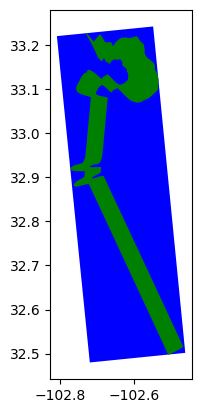

In [ ]:
# Compare selected flightline with bounding boxes in MM with flight outlines in 2024 dataset
irregular_flightline_comparison, ax = plt.subplots()
Permian2019MM[Permian2019MM['flightline']=='ang20190924t192524'].plot(color='blue', ax=ax)
Permian_flightlines_2024_irregular[Permian_flightlines_2024_irregular['scene_id']=='ang20190924t192524'].plot(color='green', ax=ax)

In [ ]:
# Wells in each version of flightline ang20190924t192524 (the very irregular one)
wells = pd.read_csv(welldata_path + 'Permian_2019_welldata.csv')
wells = cvt_point_to_geodf(wells, lonname='Surface Hole Longitude (WGS84)', latname='Surface Hole Latitude (WGS84)')
wells_in_bounding_box = gpd.tools.sjoin(wells,Permian2019MM[Permian2019MM['flightline']=='ang20190924t192524'],predicate='within',how='inner').drop('index_right', axis=1)
wells_in_irregular_flightline = gpd.tools.sjoin(wells,Permian_flightlines_2024_irregular[Permian_flightlines_2024_irregular['scene_id']=='ang20190924t192524'],predicate='within',how='inner').drop('index_right', axis=1)
wells_in_bounding_box.shape, wells_in_irregular_flightline.shape

((2489, 36), (232, 29))

In [ ]:
# Compare selected flightline with bounding boxes in MM with flight outlines in 2024 dataset
irregular_flightline_comparison, ax = plt.subplots()
Permian2019MM_notinnewdataset.plot(color='blue', ax=ax)
Permian_flightlines_2024_irregular.plot(color='green', ax=ax)
ax.set_xlim([-105, -101])
ax.set_ylim([31, 35.5])

NameError: name 'plt' is not defined

<Axes: >

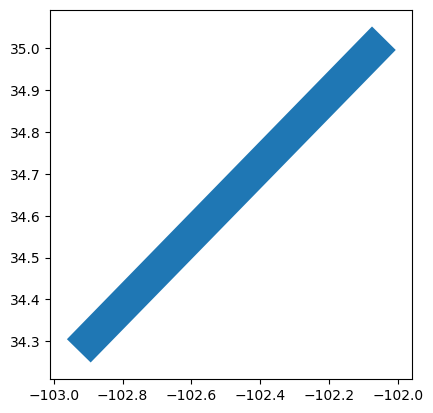

In [ ]:
# Example flightline from MM dataset that is missing radiance in 2024 dataset
Permian2019MM[Permian2019MM['flightline']=='ang20191007t161542'].plot()

In [ ]:
# Count bounding boxes in unified 2024 Permian 2019 scene dataset
from shapely import wkt
Permian_flightlines_2024_unified_imported['str_geom'] = Permian_flightlines_2024_unified_imported.geometry.apply(lambda x: wkt.dumps(x))
(Permian_flightlines_2024_unified_imported['str_geom'].str.count("-") < 10).sum(), Permian_flightlines_2024_unified_imported.shape[0]

(17, 717)

# Infrastructure coverage using EDF infrastructure database

In [61]:
# Import EDF infrastructure database
# To use this, download OGIM 2.5.1 from Omara et al. 2023, https://zenodo.org/records/13259749
import fiona
for layername in fiona.listlayers(shapedata_path + 'OGIM_v2.5.1.gpkg'):
    with fiona.open(shapedata_path + 'OGIM_v2.5.1.gpkg', layer=layername) as src:
        print(layername, len(src))
EDF_OGIM_GNP = gpd.GeoDataFrame.from_file(shapedata_path + 'OGIM_v2.5.1.gpkg', layer='Gathering_and_Processing')
EDF_OGIM_compressors = gpd.GeoDataFrame.from_file(shapedata_path + 'OGIM_v2.5.1.gpkg', layer='Natural_Gas_Compressor_Stations')
EDF_OGIM_pipelines = gpd.GeoDataFrame.from_file(shapedata_path + 'OGIM_v2.5.1.gpkg', layer='Oil_Natural_Gas_Pipelines')
EDF_OGIM_GNP.head()

Crude_Oil_Refineries 686
Equipment_and_Components 96305
Gathering_and_Processing 10550
Injection_and_Disposal 13964
LNG_Facilities 526
Natural_Gas_Compressor_Stations 12115
Natural_Gas_Flaring_Detections 9956
Offshore_Platforms 9788
Oil_Natural_Gas_Pipelines 1903711
Oil_and_Natural_Gas_Basins 709
Oil_and_Natural_Gas_Fields 17772
Oil_and_Natural_Gas_License_Blocks 2795
Oil_and_Natural_Gas_Wells 4519663
Petroleum_Terminals 3681
Stations_Other 8222
Tank_Battery 131294
Data_Catalog 185


,OGIM_ID,CATEGORY,REGION,COUNTRY,STATE_PROV,SRC_REF_ID,SRC_DATE,ON_OFFSHORE,FAC_NAME,FAC_ID,...,LIQ_CAPACITY_BPD,LIQ_THROUGHPUT_BPD,GAS_CAPACITY_MMCFD,GAS_THROUGHPUT_MMCFD,NUM_COMPR_UNITS,NUM_STORAGE_TANKS,SITE_HP,LATITUDE,LONGITUDE,geometry
0,96992,GATHERING AND PROCESSING,AFRICA,LIBYA,SURT,22,2014-01-01,ONSHORE,MABRUK,N/A,...,-999.0,-999.0,-999.0,-999.0,-999,-999,-999.0,29.82558,17.29172,POINT (17.29172 29.82558)
1,96993,GATHERING AND PROCESSING,AFRICA,LIBYA,AJDABIYA,22,2014-01-01,ONSHORE,N/A,N/A,...,-999.0,-999.0,-999.0,-999.0,-999,-999,-999.0,28.00636,21.30742,POINT (21.30742 28.00636)
2,96994,GATHERING AND PROCESSING,AFRICA,LIBYA,WADI AL HAYAA,22,2014-01-01,ONSHORE,B-NC115,N/A,...,-999.0,-999.0,-999.0,-999.0,-999,-999,-999.0,26.43138,11.85065,POINT (11.85065 26.43138)
3,96995,GATHERING AND PROCESSING,AFRICA,LIBYA,WADI AL HAYAA,22,2014-01-01,ONSHORE,A-NC115,N/A,...,-999.0,-999.0,-999.0,-999.0,-999,-999,-999.0,26.57915,12.20913,POINT (12.20913 26.57915)
4,96996,GATHERING AND PROCESSING,AFRICA,LIBYA,AL JUFRAH,22,2014-01-01,ONSHORE,BI'R ZALATAN,N/A,...,-999.0,-999.0,-999.0,-999.0,-999,-999,-999.0,28.16486,19.16845,POINT (19.16845 28.16486)


In [62]:
# Extract infrastructure in the Permian
basins = gpd.GeoDataFrame.from_file(shapedata_path + 'AAPGGeologicProvinces.shp')
Permian_basin = basins[basins['Name']=='Permian basin']
EDF_Permian_GNP = gpd.tools.sjoin(EDF_OGIM_GNP,Permian_basin,predicate='within',how='inner').drop('index_right', axis=1)
EDF_Permian_compressors = gpd.tools.sjoin(EDF_OGIM_compressors,Permian_basin,predicate='within',how='inner').drop('index_right', axis=1)
# EDF_Permian_pipelines = gpd.tools.sjoin(EDF_OGIM_pipelines,Permian_basin,predicate='within',how='inner').drop('index_right', axis=1)
EDF_Permian_GNP.shape, EDF_Permian_compressors.shape #, EDF_Permian_pipelines.shape

((102, 31), (247, 31))

<Axes: >

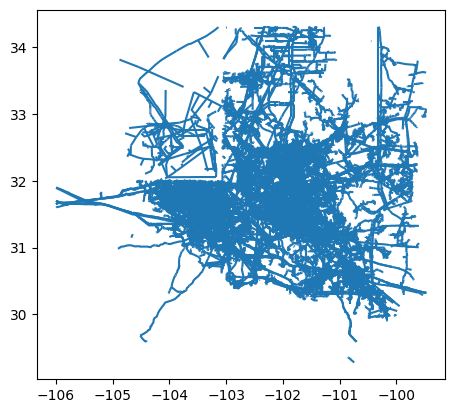

In [63]:
# EDF_Permian_GNP.plot()
# EDF_Permian_compressors.plot()
# Includes all natural gas-related pipelines (but not oil)
EDF_TXNM_pipelines = EDF_OGIM_pipelines[((EDF_OGIM_pipelines['STATE_PROV'] == 'TEXAS') | (EDF_OGIM_pipelines['STATE_PROV'] == 'NEW MEXICO')) & (EDF_OGIM_pipelines.COMMODITY.str.contains('NATURAL GAS'))]
EDF_Permian_pipelines = gpd.tools.sjoin(EDF_TXNM_pipelines,Permian_basin,predicate='within',how='inner').drop('index_right', axis=1)
# EDF_TXNM_pipelines.plot()
EDF_Permian_pipelines.plot()

In [64]:
# Total pipeline length in the Permian
EDF_Permian_pipelines_length = EDF_Permian_pipelines.PIPE_LENGTH_KM.sum()
EDF_Permian_pipelines_length

np.float64(145607.556568206)

<Axes: >

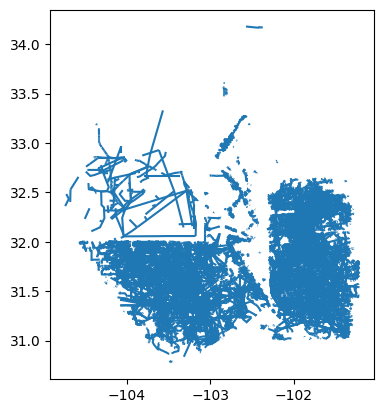

In [65]:
# Covered pipeline length in the Permian (using the dataset for the 2019 campaign that was provided in 2024, which includes high-fidelity shapefiles instead of bounding boxes)
Permian_flightlines_2024_unified_imported_merged = Permian_flightlines_2024_unified_imported.dissolve()
EDF_Permian_pipelines_covered_2019 = gpd.tools.sjoin(EDF_Permian_pipelines,Permian_flightlines_2024_unified_imported_merged,predicate='within',how='inner').drop('index_right', axis=1)
EDF_Permian_pipelines_covered_2019.plot()

In [66]:
# Covered pipeline length in the Permian 2019
EDF_Permian_pipelines_length_covered_2019 = EDF_Permian_pipelines_covered_2019.PIPE_LENGTH_KM.sum()
EDF_Permian_pipelines_length_covered_2019

np.float64(69353.690576466)

In [67]:
# Pipeline visits, including repeats in the Permian in 2019
EDF_Permian_pipelines_covered_2019_inc_repeats = gpd.tools.sjoin(EDF_Permian_pipelines,Permian_flightlines_2024_unified_imported,predicate='within',how='inner').drop('index_right', axis=1)
EDF_Permian_pipelines_length_covered_2019_inc_repeats_length_covered = EDF_Permian_pipelines_covered_2019_inc_repeats.PIPE_LENGTH_KM.sum()
EDF_Permian_pipelines_length_covered_2019_inc_repeats_length_covered

np.float64(127176.671087272)

In [68]:
EDF_Permian_pipelines_covered_2019.COMMODITY.unique()

array(['NATURAL GAS', 'NATURAL GAS, GATHERING',
       'NATURAL GAS, TRANSMISSION',
       'NATURAL GAS, FULL WELL STREAM GATHERING'], dtype=object)

# Determine AVIRIS bounding boxes

In [ ]:
# Find AVIRIS-NG scenes that are actually just bounding boxes
# Save flightline IDs and dates to CSV file
Permian2019MM = gpd.GeoDataFrame.from_file(shapedata_path + 'Permian_2019' + '.shp')

# Drop 'P000#' from GAO scene IDs
Permian2019MM['flightline'] = (Permian2019MM['flightline'].str.split('p', expand=True)).iloc[:,0]

In [ ]:
# Identify number of coordinates in geometry
from shapely import wkt
Permian2019MM['str_geom'] = Permian2019MM.geometry.apply(lambda x: wkt.dumps(x))
(Permian2019MM['str_geom'].str.count("-") < 10).sum(), Permian2019MM.shape[0]

TypeError: Series.count() takes 1 positional argument but 2 were given

In [ ]:
campaign_shapefile_names = ['Permian_2019', 'Permian_2020', 'Permian_fall2021', 'Permian_summer2021', 'Cal_2016', 'Cal_2017', 'Cal_fall2020', 'Cal_summer2020', 'Cal_fall2021', 'Denver_summer2021', 'Denver_fall2021', 'Northeast_2021', 'Utah_2020'] #

In [ ]:
from shapely import wkt
for jj in campaign_shapefile_names:
  campaign_shapefiles = gpd.GeoDataFrame.from_file(shapedata_path + jj + '.shp')
  campaign_shapefiles['str_geom'] = campaign_shapefiles.geometry.apply(lambda x: wkt.dumps(x))
  print([jj, (campaign_shapefiles['str_geom'].str.count("-") < 10).sum(), campaign_shapefiles.shape[0]])

['Permian_2019', 355, 703]
['Permian_2020', 0, 156]
['Permian_fall2021', 0, 265]
['Permian_summer2021', 0, 462]
['Cal_2016', 522, 522]
['Cal_2017', 1178, 1178]
['Cal_fall2020', 0, 421]
['Cal_summer2020', 446, 446]
['Cal_fall2021', 0, 204]
['Denver_summer2021', 0, 180]
['Denver_fall2021', 0, 197]
['Northeast_2021', 0, 138]
['Utah_2020', 0, 154]


In [ ]:
# Scene area summary stats of campign shape
slct_percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
campaign_shapefiles[campaign_shapefiles['str_geom'].str.count("-") < 10].Shape_Area.describe(percentiles=slct_percentiles)

,Shape_Area
count,446.000000
mean,0.004857
std,0.007342
min,0.000311
1%,0.000571
5%,0.001093
10%,0.001284
25%,0.001650
50%,0.002936
75%,0.006155


In [ ]:
# Scene area summary stats of campign shape
campaign_shapefiles.Shape_Area.describe(percentiles=slct_percentiles)

,Shape_Area
count,1178.000000
mean,0.003948
std,0.004655
min,0.000156
1%,0.000528
5%,0.000661
10%,0.000983
25%,0.001242
50%,0.002441
75%,0.005345


In [ ]:
campaign_shapefiles.Shape_Leng.describe(percentiles=slct_percentiles)

,Shape_Leng
count,1178.000000
mean,0.426556
std,0.288880
min,0.050840
1%,0.107433
5%,0.167632
10%,0.194529
25%,0.218095
50%,0.321912
75%,0.521090


<Axes: >

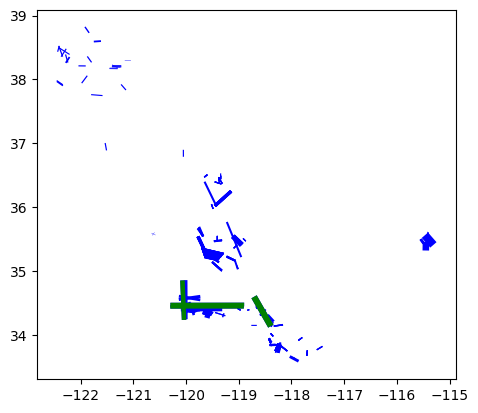

In [ ]:
# selected_campaign = 'Cal_2017' # 'Cal_summer2020' # 'Cal_2016' # 'Cal_2017'
# campaign_shapefiles = gpd.GeoDataFrame.from_file(shapedata_path + selected_campaign + '.shp')
flightline_comparison, ax = plt.subplots()
campaign_shapefiles.plot(ax=ax, color='blue')
# campaign_shapefiles[campaign_shapefiles['str_geom'].str.count("-") < 10].plot(ax=ax, color='green')
campaign_shapefiles[campaign_shapefiles.Shape_Area > 0.04].plot(ax=ax, color='green')


In [ ]:
campaign_shapefiles[campaign_shapefiles.Shape_Area > 0.04]

,OBJECTID,flightline,date,datetime,platform,campaign,Shape_Leng,Shape_Area,geometry,str_geom
73,74,ang20200724t184755,2020-07-24,2020-07-24T18:47:55Z,ang,Cal_summer2020,1.340631,0.061398,"POLYGON ((-118.44242 34.11711, -118.76097 34.5...",POLYGON ((-118.4424220000752257 34.11711499995...
126,127,ang20200731t193625,2020-07-31,2020-07-31T19:36:25Z,ang,Cal_summer2020,1.409012,0.053121,"POLYGON ((-120.08205 34.23725, -120.11274 34.8...",POLYGON ((-120.0820519997000133 34.23725300032...
128,129,ang20200731t201606,2020-07-31,2020-07-31T20:16:06Z,ang,Cal_summer2020,2.916267,0.081753,"POLYGON ((-120.29887 34.50705, -118.89866 34.5...",POLYGON ((-120.2988749998813205 34.50704999995...
129,130,ang20200731t203733,2020-07-31,2020-07-31T20:37:33Z,ang,Cal_summer2020,2.892216,0.070224,"POLYGON ((-120.30092 34.46515, -118.9047 34.46...",POLYGON ((-120.3009150004268690 34.46514600018...
